In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'axes.labelsize': 9,
    'text.color': '#222222',
    'font.sans-serif' : 'Helvetica',
    'text.usetex': False,
    'figure.figsize': (7.2, 4.45),
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='paper', rc=rc_params,
        font_scale=1.0)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [3]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data()

In [4]:
from dask.distributed import Client

Client(n_workers=2,
       threads_per_worker=2,
       processes=True,
       memory_limit='25GB')

<Client: 'tcp://127.0.0.1:58236' processes=2 threads=4, memory=32.00 GiB>

In [5]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay


from replay_trajectory_classification import SortedSpikesClassifier, SortedSpikesDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)



INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='', movement_var=33.31009971953083, movement_mean=0.0),
                                                     Uniform(environment_name='', environment2_name=None),
                                                     Identity(environment_name='')],
                                                    [Uniform(environment_name='', environment2_name=None),
                                                     Uniform(environment_name='', environment2_name=None),
                                                     Uniform(environment_name='',...
                       environments=(Environment(environment_name='', place_bin_size=0.5268625668325884, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True),),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
             

In [6]:
from replay_trajectory_classification import SortedSpikesDecoder
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

stationary_decoder = SortedSpikesDecoder(environment=environment,
                    transition_type=Identity(),
                    spike_model_penalty=0.5).fit(linear_distance, spikes)

continuous_decoder = SortedSpikesDecoder(environment=environment,
                    transition_type=RandomWalk(movement_var=movement_var * 120),
                    spike_model_penalty=0.5).fit(linear_distance, spikes)

fragmented_decoder = SortedSpikesDecoder(environment=environment,
                    transition_type= Uniform(),
                    spike_model_penalty=0.5).fit(linear_distance, spikes)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...
INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...
INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


In [7]:
from replay_trajectory_classification.misc import TRANSITION_TO_CATEGORY, STATE_COLORS

def plot_classification(replay_time, test_spikes, results):
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3)
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel('Neuron Index')
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        axes[1].plot(prob.time, prob.values, linewidth=4, label=state, color=STATE_COLORS[state])
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].legend(bbox_to_anchor=(1.15, 0.95), loc='upper right', fancybox=False, shadow=False,
                   ncol=1, frameon=False)
    
    results.acausal_posterior.sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Position [cm]')
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [s]')
    sns.despine()


def plot_discrete_state_transition(discrete_state_transition, state_names=None, cmap='Oranges', ax=None,
                                   convert_to_seconds=False, sampling_frequency=1):
    if ax is None:
        ax = plt.gca()
    n_states = discrete_state_transition.shape[0]
    
    if convert_to_seconds:
        discrete_state_transition = (1 / (1 - discrete_state_transition)) / sampling_frequency
        vmin, vmax, fmt = 0.0, None, '0.03f'
        label = 'Seconds'
    else:
        vmin, vmax, fmt = 0.0, 1.0, '0.03f'
        label = 'Probability'

    sns.heatmap(data=discrete_state_transition,
                vmin=vmin, vmax=vmax, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=state_names, yticklabels=state_names, ax=ax,
                cbar_kws={'label': label})
    ax.set_ylabel('Previous State', fontsize=12)
    ax.set_xlabel('Current State', fontsize=12)
    ax.set_title('Discrete State Transition', fontsize=16)

## Test Data Log Likelihood

### Test that likelihood improves for the correct continuous state transition model.

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<BarContainer object of 4 artists>

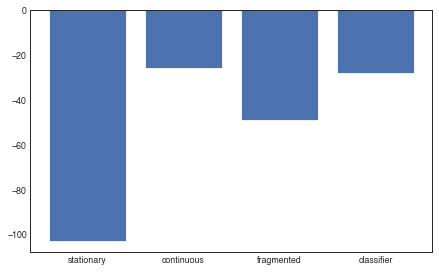

In [8]:
from replay_trajectory_classification.sorted_spikes_simulation import make_continuous_replay

replay_time, test_spikes = make_continuous_replay()

stationary_log_likelihood = stationary_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
continuous_log_likelihood = continuous_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
fragmented_log_likelihood = fragmented_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
classifier_log_likelihood = classifier.predict(test_spikes, time=replay_time).data_log_likelihood


plt.bar(['stationary', 'continuous', 'fragmented', 'classifier'],
        [stationary_log_likelihood, continuous_log_likelihood, fragmented_log_likelihood, classifier_log_likelihood])

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<BarContainer object of 4 artists>

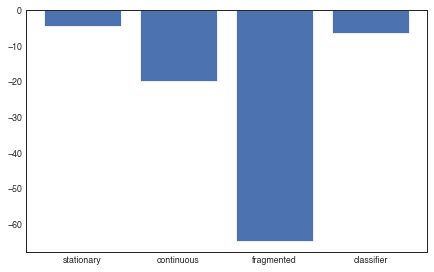

In [9]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_replay

replay_time, test_spikes = make_hover_replay()

stationary_log_likelihood = stationary_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
continuous_log_likelihood = continuous_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
fragmented_log_likelihood = fragmented_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
classifier_log_likelihood = classifier.predict(test_spikes, time=replay_time).data_log_likelihood


plt.bar(['stationary', 'continuous', 'fragmented', 'classifier'],
        [stationary_log_likelihood, continuous_log_likelihood, fragmented_log_likelihood, classifier_log_likelihood])

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<BarContainer object of 4 artists>

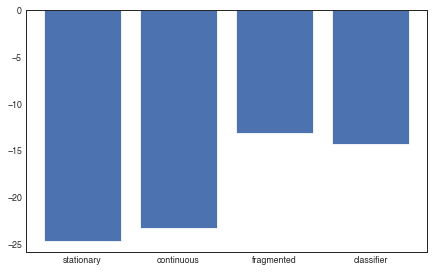

In [10]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_replay

replay_time, test_spikes = make_fragmented_replay()

stationary_log_likelihood = stationary_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
continuous_log_likelihood = continuous_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
fragmented_log_likelihood = fragmented_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
classifier_log_likelihood = classifier.predict(test_spikes, time=replay_time).data_log_likelihood


plt.bar(['stationary', 'continuous', 'fragmented', 'classifier'],
        [stationary_log_likelihood, continuous_log_likelihood, fragmented_log_likelihood, classifier_log_likelihood])

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<BarContainer object of 4 artists>

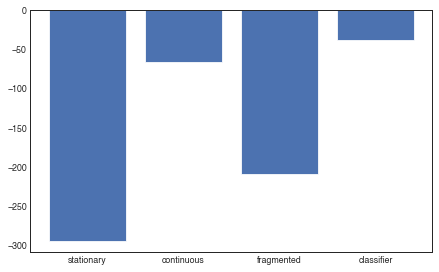

In [11]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay

replay_time, test_spikes = make_hover_continuous_hover_replay()

stationary_log_likelihood = stationary_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
continuous_log_likelihood = continuous_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
fragmented_log_likelihood = fragmented_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
classifier_log_likelihood = classifier.predict(test_spikes, time=replay_time).data_log_likelihood


plt.bar(['stationary', 'continuous', 'fragmented', 'classifier'],
        [stationary_log_likelihood, continuous_log_likelihood, fragmented_log_likelihood, classifier_log_likelihood])

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<BarContainer object of 4 artists>

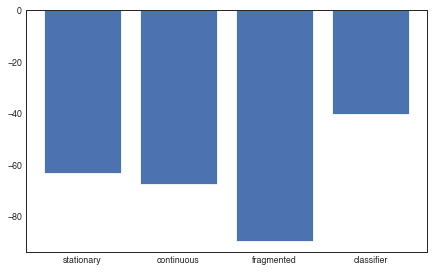

In [12]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_hover_fragmented_replay

replay_time, test_spikes = make_fragmented_hover_fragmented_replay()

stationary_log_likelihood = stationary_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
continuous_log_likelihood = continuous_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
fragmented_log_likelihood = fragmented_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
classifier_log_likelihood = classifier.predict(test_spikes, time=replay_time).data_log_likelihood


plt.bar(['stationary', 'continuous', 'fragmented', 'classifier'],
        [stationary_log_likelihood, continuous_log_likelihood, fragmented_log_likelihood, classifier_log_likelihood])

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<BarContainer object of 4 artists>

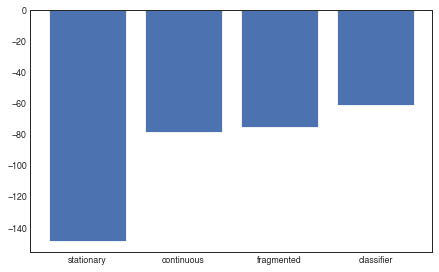

In [13]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_continuous_fragmented_replay

replay_time, test_spikes = make_fragmented_continuous_fragmented_replay()

stationary_log_likelihood = stationary_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
continuous_log_likelihood = continuous_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
fragmented_log_likelihood = fragmented_decoder.predict(test_spikes, time=replay_time).data_log_likelihood
classifier_log_likelihood = classifier.predict(test_spikes, time=replay_time).data_log_likelihood


plt.bar(['stationary', 'continuous', 'fragmented', 'classifier'],
        [stationary_log_likelihood, continuous_log_likelihood, fragmented_log_likelihood, classifier_log_likelihood])

### Test that correct discrete state transition leads to better likelihood

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...


-28.090729785603394


INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-25.964600096297684


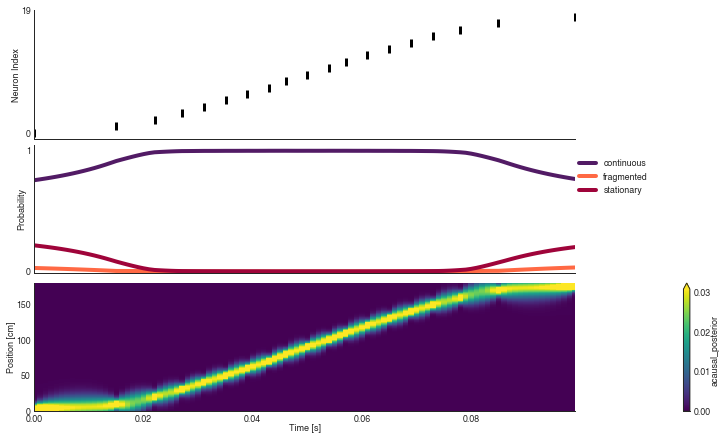

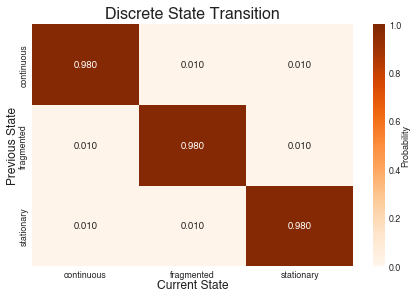

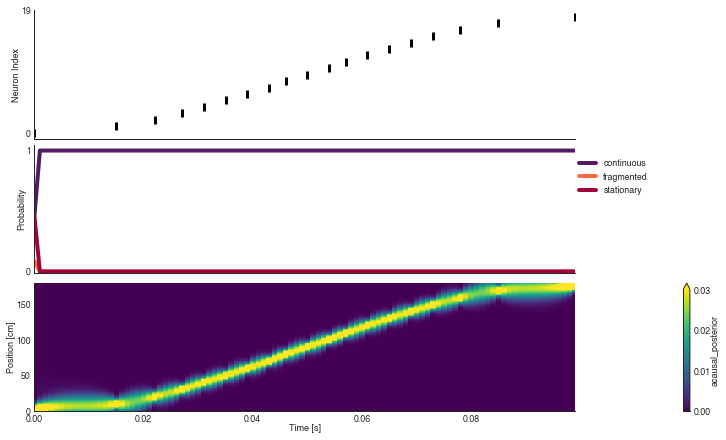

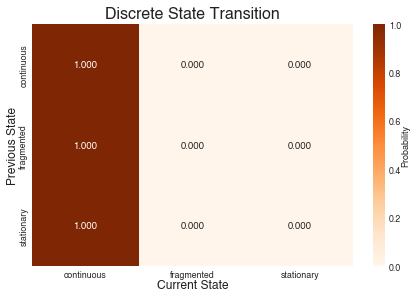

In [14]:
replay_time, test_spikes = make_continuous_replay()


state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier2 = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier2.fit(linear_distance, spikes)

A = np.zeros((3, 3))
A[:, 0] = 1
classifier2.discrete_state_transition_ = A

results = classifier2.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier2.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)


### Test that the incorrect discrete state transition leads to a worse likelihood

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-37.790552447011265


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-66.70738803728104


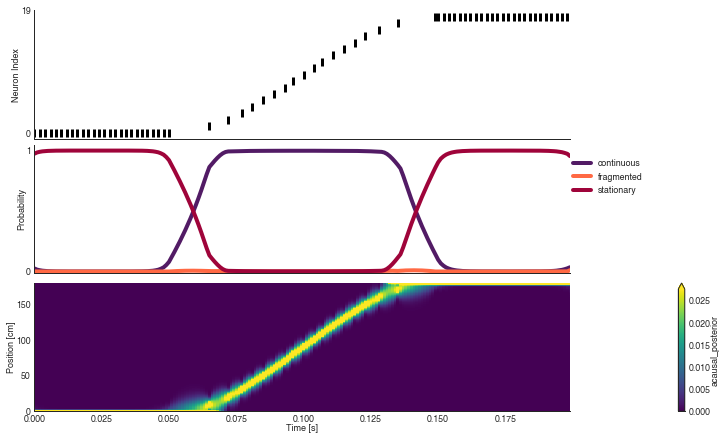

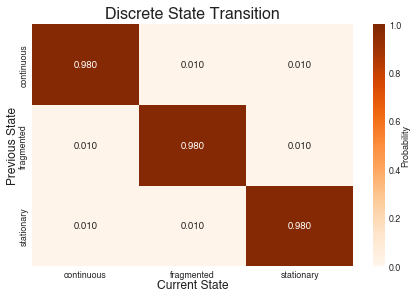

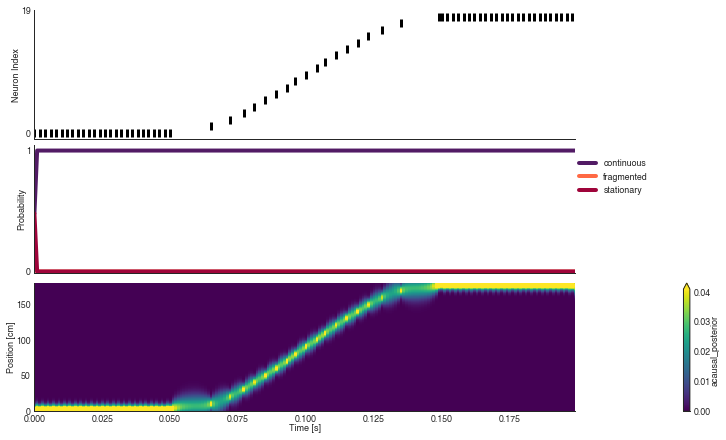

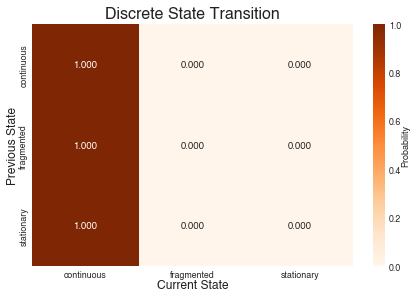

In [15]:
replay_time, test_spikes = make_hover_continuous_hover_replay()


state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)


A = np.zeros((3, 3))
A[:, 0] = 1
classifier2.discrete_state_transition_ = A

results = classifier2.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier2.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)

### Test that correct discrete state transition leads to better likelihood

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-37.790552447011265


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-35.83297878009731


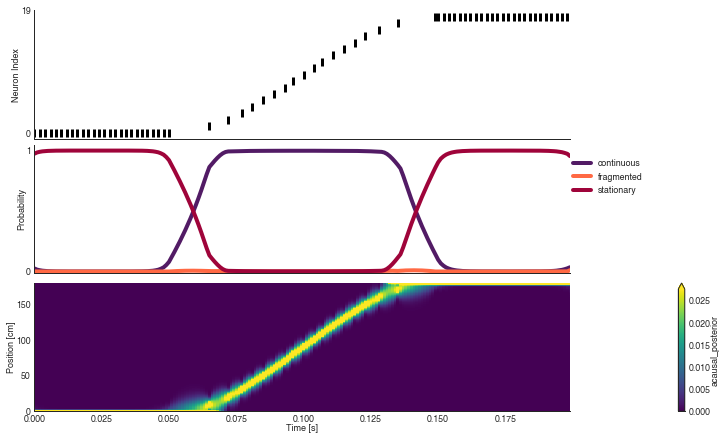

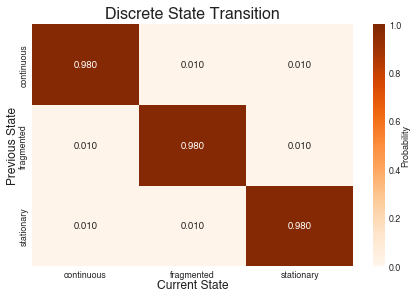

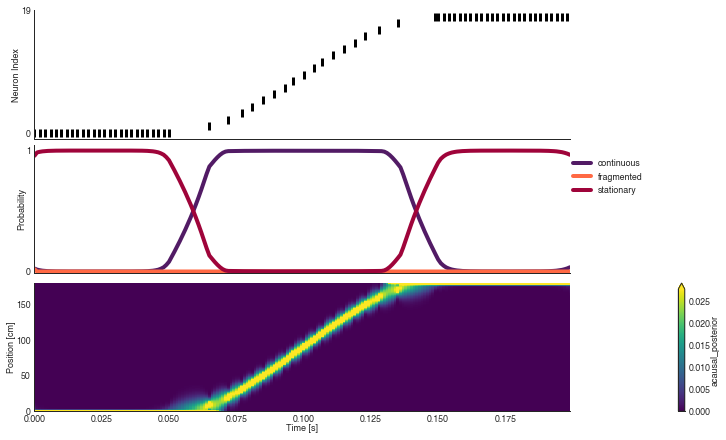

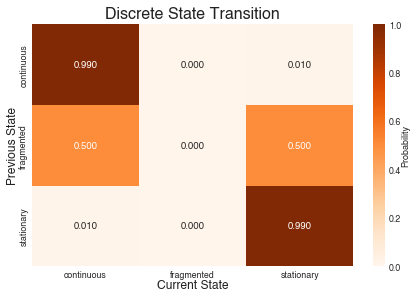

In [16]:
replay_time, test_spikes = make_hover_continuous_hover_replay()


state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)


A = np.zeros((3, 3))
A[0, 0] = 1 - (1 / make_continuous_replay()[0].shape[0])
A[0, 2] = 1 / make_continuous_replay()[0].shape[0]
A[2, 2] = 1 - (1 / (make_hover_replay()[0].shape[0] * 2))
A[2, 0] = 1 / (make_hover_replay()[0].shape[0] * 2)
A[1, 1] = 0.0
A[1, ::2] = 0.5
classifier2.discrete_state_transition_ = A

results = classifier2.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier2.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-53.238877294284556


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-50.078644728988344


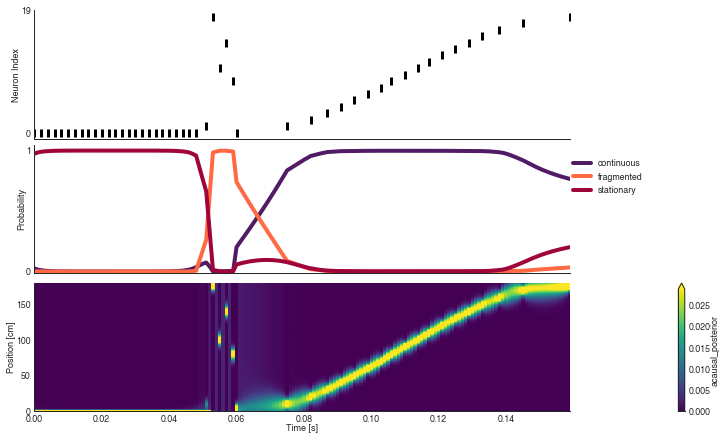

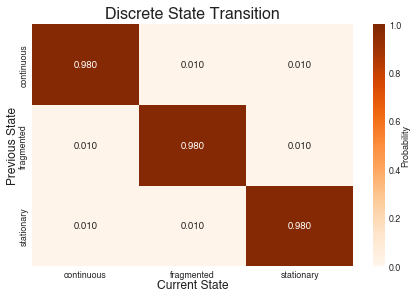

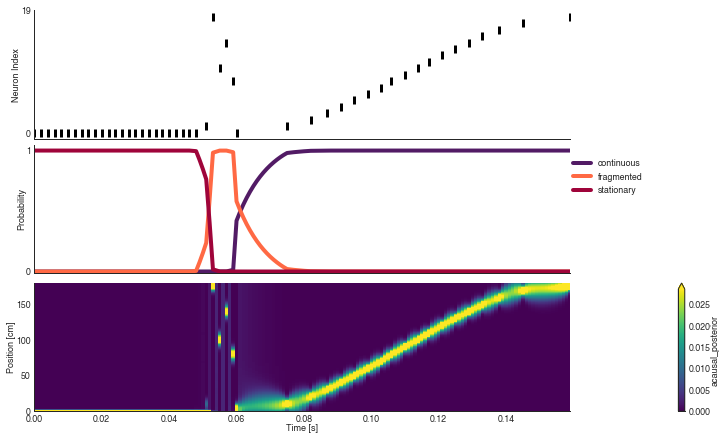

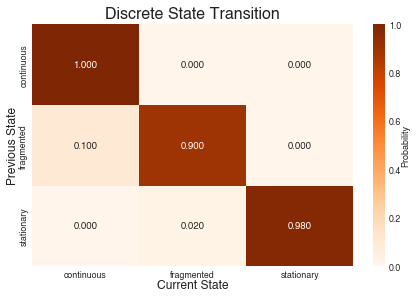

In [17]:
_, test_spikes1 = make_hover_replay(hover_neuron_ind=0)
_, test_spikes2 = make_fragmented_replay()
_, test_spikes3 = make_continuous_replay()

test_spikes = np.concatenate((test_spikes1, test_spikes2, test_spikes3))
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)


A = np.zeros((3, 3))
A[0, 0] = 1


A[1, 1] = 1 - (1 / make_fragmented_replay()[0].shape[0])
A[1, 0] = (1 / make_fragmented_replay()[0].shape[0])

A[2, 2] = 1 - (1 / (make_hover_replay()[0].shape[0]))
A[2, 1] = 1 / (make_hover_replay()[0].shape[0])
classifier2.discrete_state_transition_ = A

results = classifier2.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
plt.figure()
plot_discrete_state_transition(classifier2.discrete_state_transition_, state_names=state_names)
print(results.data_log_likelihood)

## Estimating transition matrix

$$
\begin{align}
Pr(I_{k}, I_{k+1} \mid O_{1:T}) & = Pr(I_{k} \mid I_{k+1}, O_{1:T}) Pr(I_{k+1} \mid O_{1:T})
\\ & = Pr(I_{k} \mid I_{k+1}, O_{1:k}) Pr(I_{k+1} \mid O_{1:T}) % markov
\\ & = \frac{Pr(I_{k}, I_{k+1} \mid O_{1:k})}{Pr(I_{k+1} \mid O_{1:k})} Pr(I_{k+1} \mid O_{1:T})
\\ & = \frac{Pr(I_{k+1} \mid I_{k},  O_{1:k}) Pr(I_{k} \mid O_{1:k})}{Pr(I_{k+1} \mid O_{1:k})} Pr(I_{k+1} \mid O_{1:T})
\\ & = \frac{Pr(I_{k+1} \mid I_{k}) Pr(I_{k} \mid O_{1:k})}{Pr(I_{k+1} \mid O_{1:k})} Pr(I_{k+1} \mid O_{1:T})
\end{align}
$$

$$
Pr(I_{k} = i, I_{k+1} = j \mid O_{1:T}) = \frac{Pr(I_{k+1} = j \mid I_{k} = i) Pr(I_{k} = i \mid O_{1:k})}{Pr(I_{k+1} = j \mid O_{1:k})} Pr(I_{k+1} = j \mid O_{1:T})
$$

In [18]:
def estimate_discrete_state_transition(old_discrete_state_transition, causal_prob, acausal_prob):
    n_states = old_discrete_state_transition.shape[0]
    new_discrete_state_transition = np.zeros((n_states, n_states))
    for i in range(n_states):
        for j in range(n_states):
            new_discrete_state_transition[i, j] = (
                old_discrete_state_transition[i, j] *
                causal_prob[:-1, i] *
                acausal_prob[1:, j] /
                causal_prob[1:, j]).sum() + 1e-32
            new_discrete_state_transition[i, j] /= acausal_prob[:-1, i].sum()
    new_discrete_state_transition /= new_discrete_state_transition.sum(axis=-1, keepdims=True)
    
    return new_discrete_state_transition

old_discrete_state_transition = classifier.discrete_state_transition_
causal_prob = results.causal_posterior.sum('position').values
acausal_prob = results.acausal_posterior.sum('position').values

estimate_discrete_state_transition(old_discrete_state_transition, causal_prob, acausal_prob)

array([[9.90096875e-01, 2.95421243e-03, 6.94891294e-03],
       [1.35995456e-02, 9.80515994e-01, 5.88446003e-03],
       [5.66632365e-07, 9.35003613e-03, 9.90649397e-01]])

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-7.51152430887634


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-6.245352537455882


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-6.024961818533079


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-5.966243051415531


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-5.937263908235168


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-5.91989973293844


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-5.90853565219458


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-5.900736146071134


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-5.895233003199516


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-5.891284221852744


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-5.888420571162714


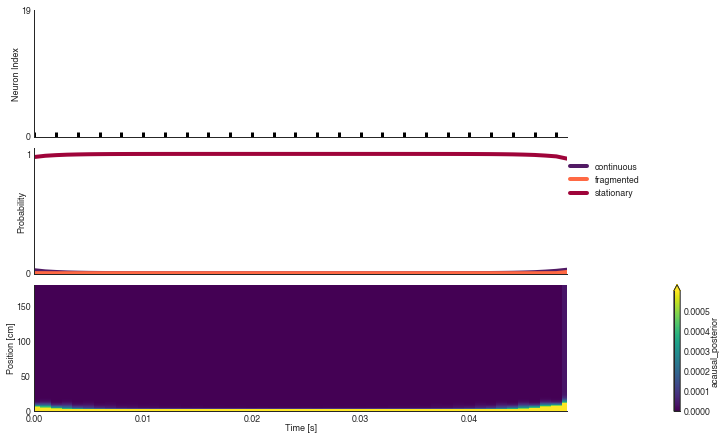

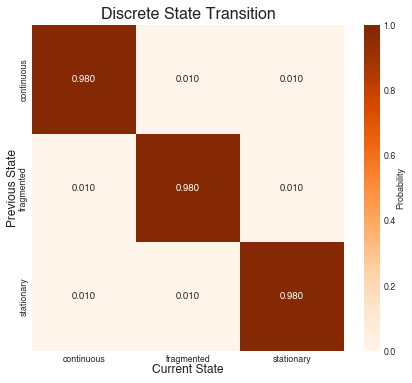

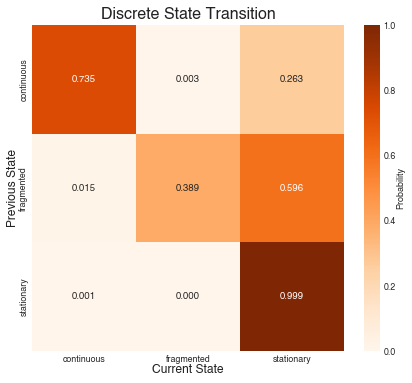

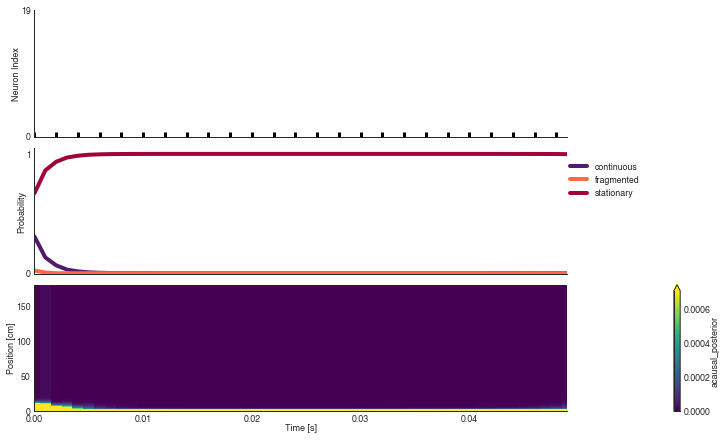

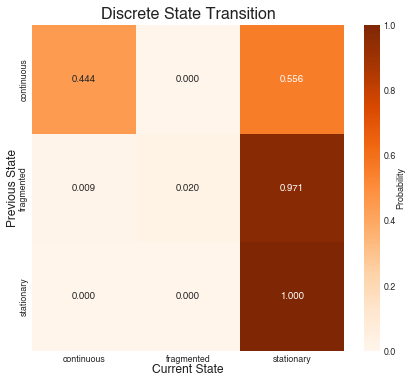

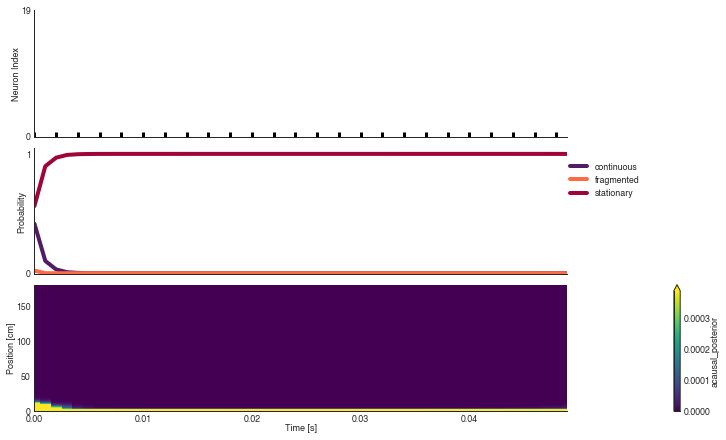

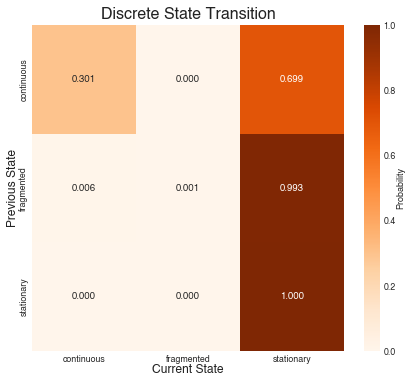

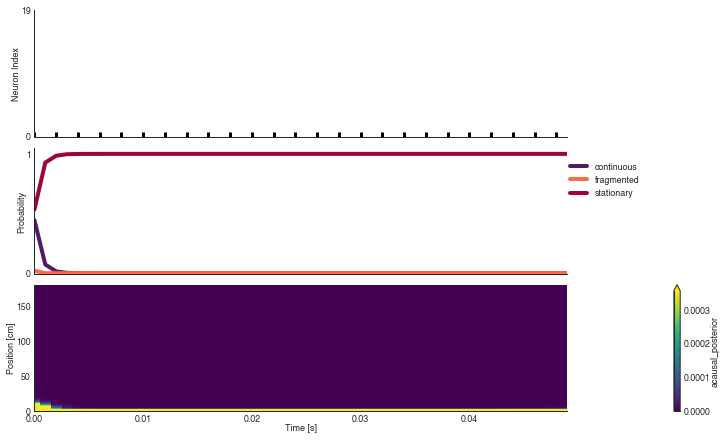

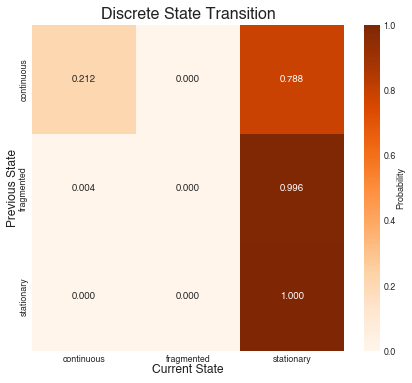

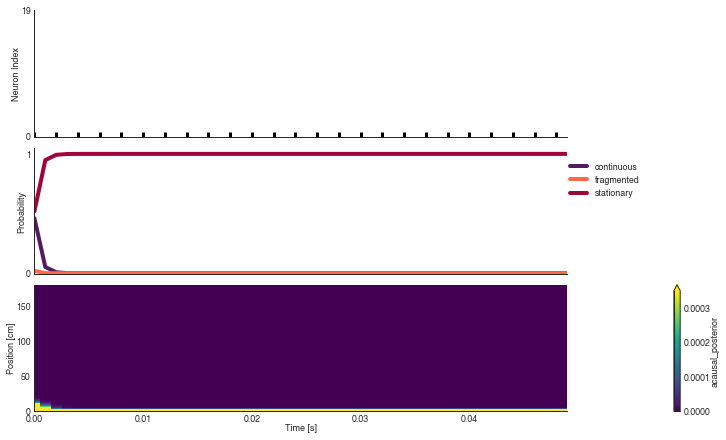

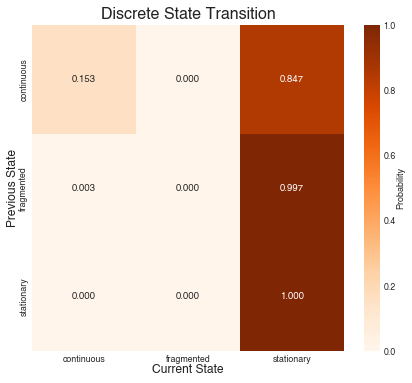

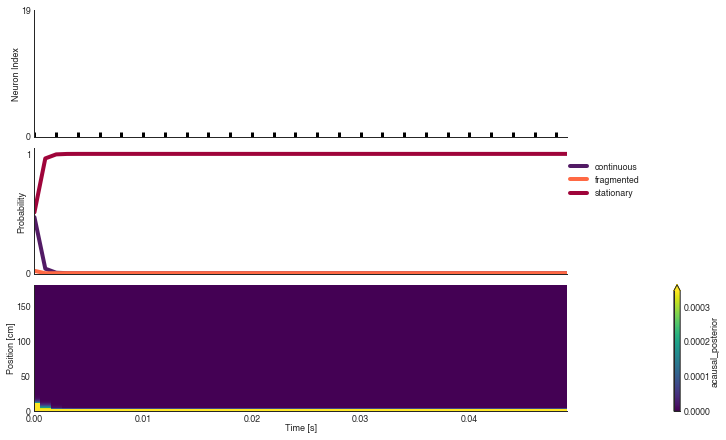

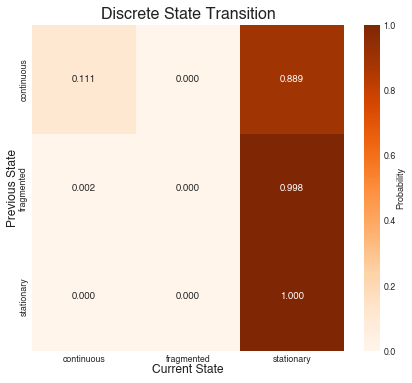

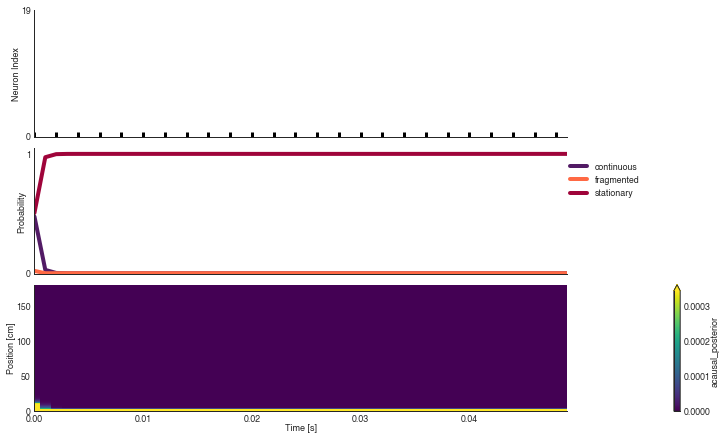

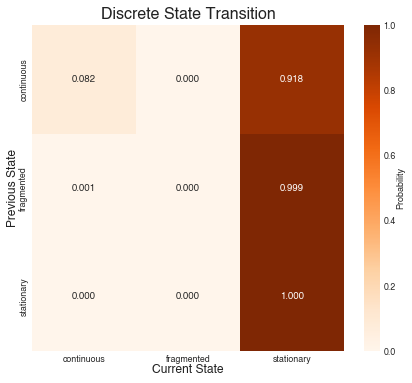

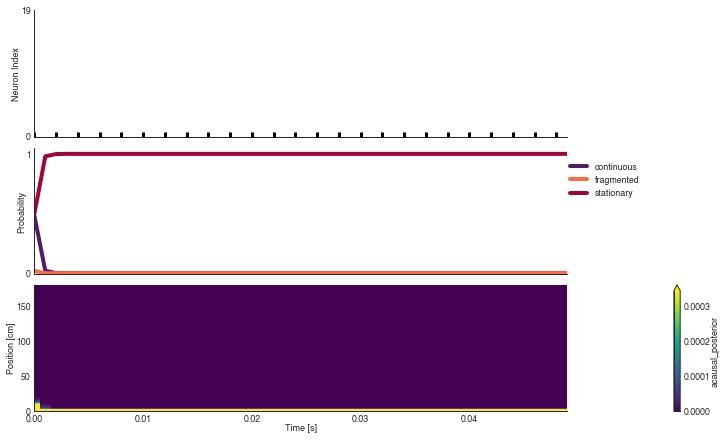

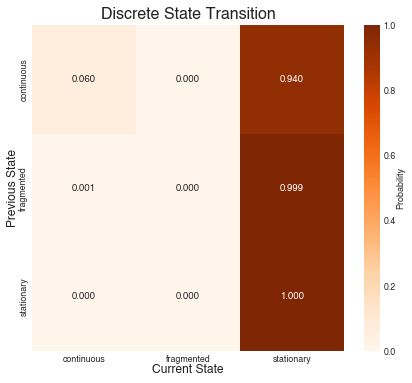

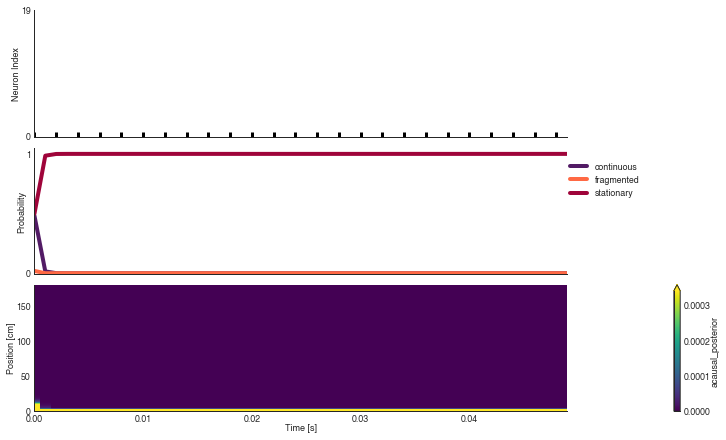

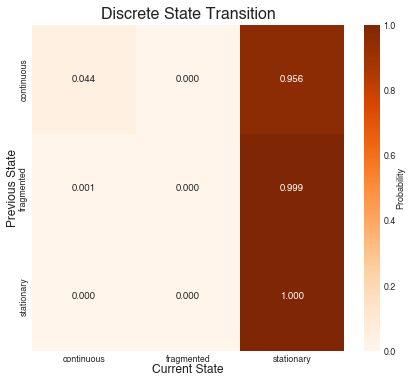

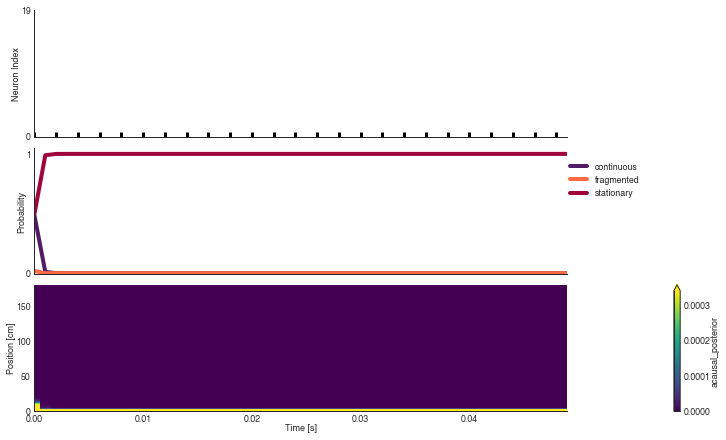

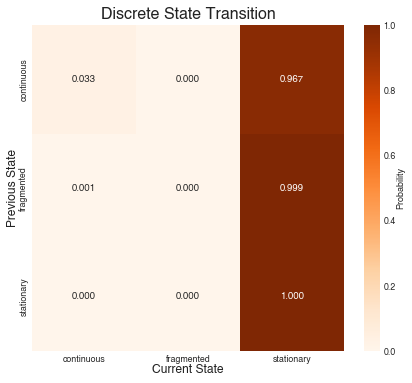

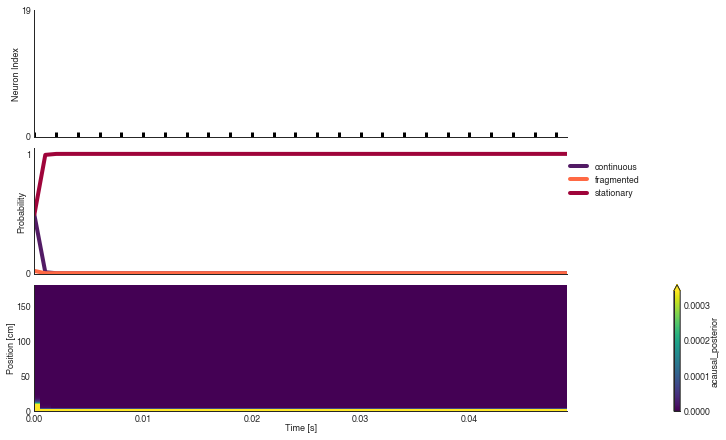

In [19]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)

_, test_spikes1 = make_hover_replay(hover_neuron_ind=0)

test_spikes = test_spikes1
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

state_names = ['continuous', 'fragmented', 'stationary']

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
print(results.data_log_likelihood)

plt.figure(figsize=(7, 6))  
plot_discrete_state_transition(
    classifier.discrete_state_transition_, state_names=state_names)

for _ in range(10):
    old_discrete_state_transition = classifier.discrete_state_transition_
    causal_prob = results.causal_posterior.sum('position').values
    acausal_prob = results.acausal_posterior.sum('position').values
    A = estimate_discrete_state_transition(old_discrete_state_transition, causal_prob, acausal_prob)
    plt.figure(figsize=(7, 6))  
    plot_discrete_state_transition(A, state_names=state_names)
    
    classifier.discrete_state_transition_ = A
    results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
    plot_classification(replay_time, test_spikes, results)

    print(results.data_log_likelihood)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-28.090729785603394


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-26.159659042611555


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-25.972295094950354


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-25.9409981197827


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-25.93040440993389


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-25.923885685844073


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-25.918536974870705


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-25.91410544904809


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-25.910609150356542


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-25.90796781629675


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-25.906036899716295


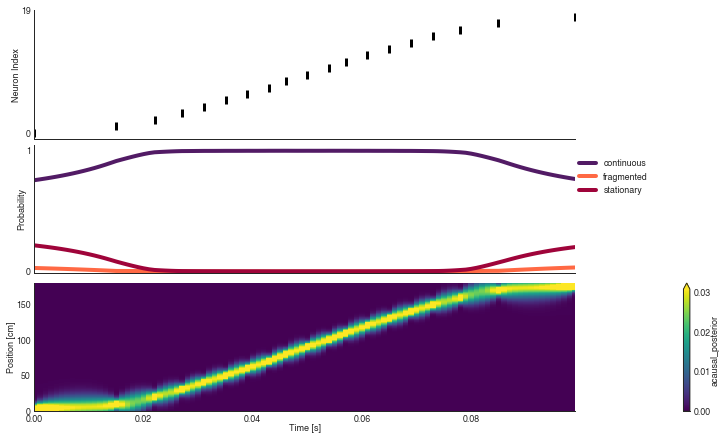

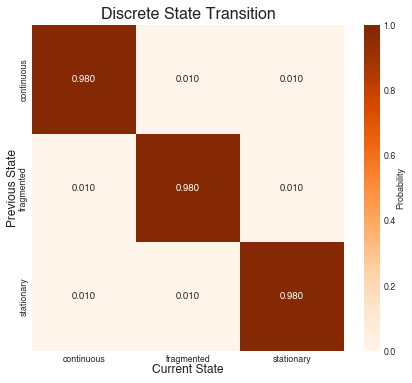

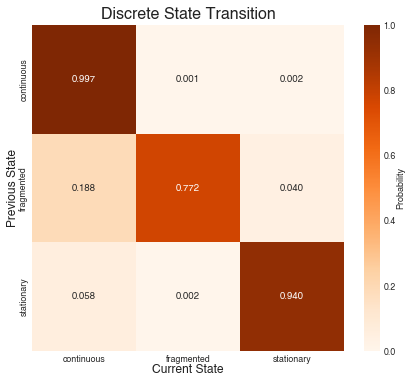

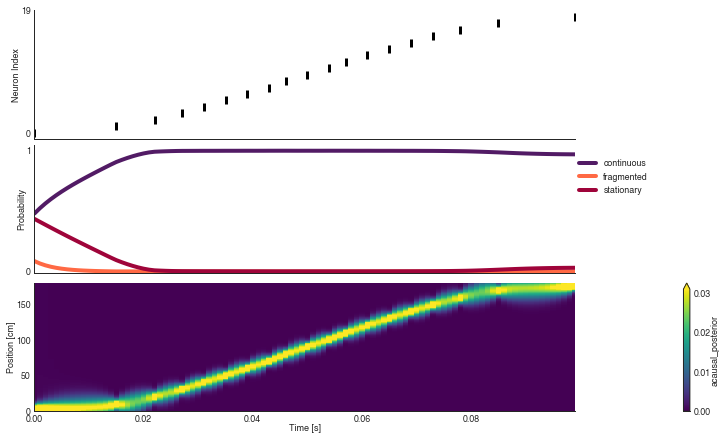

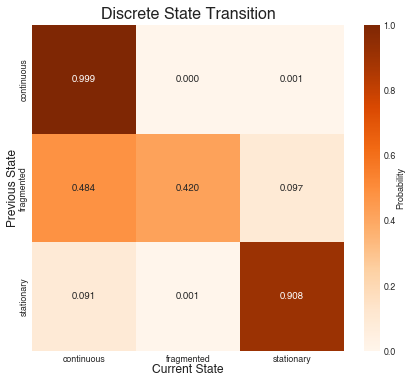

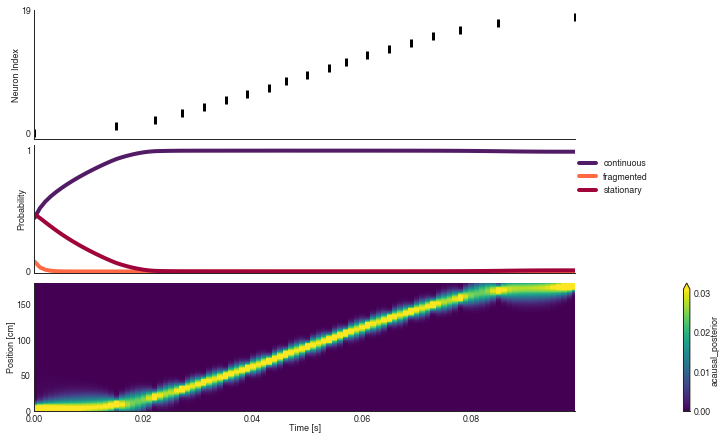

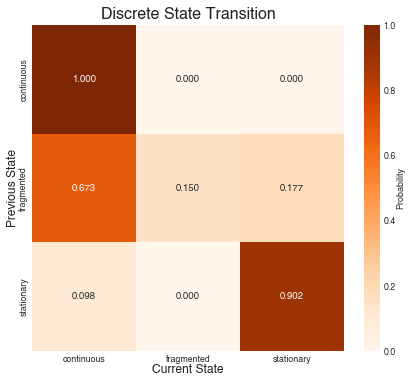

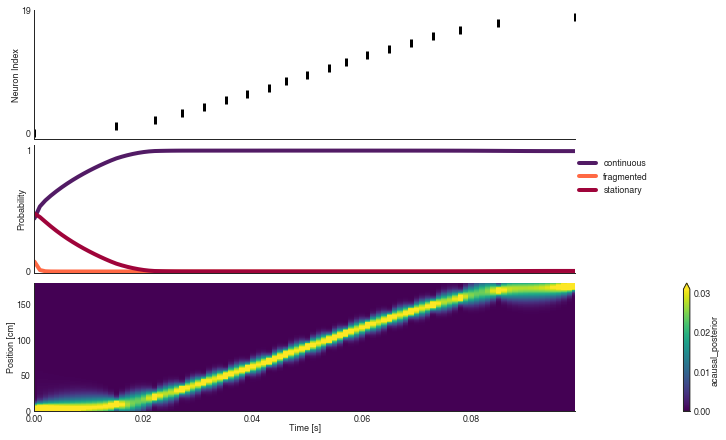

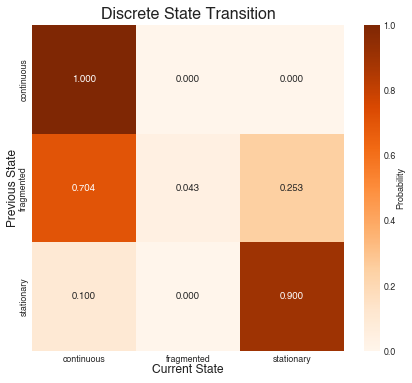

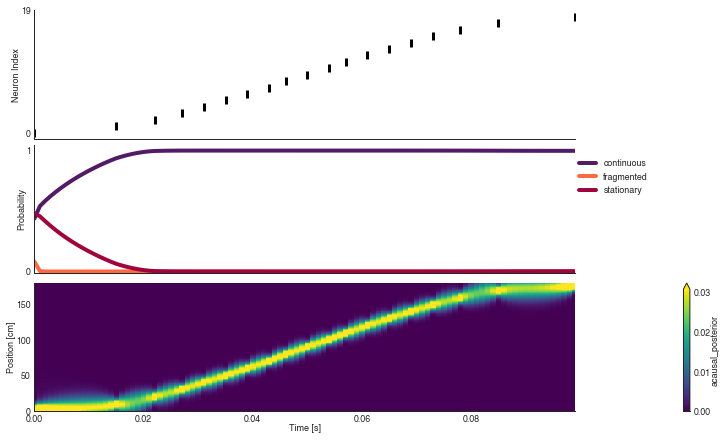

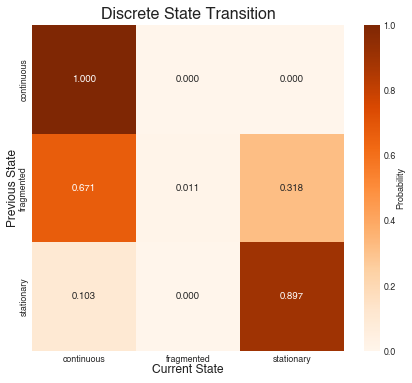

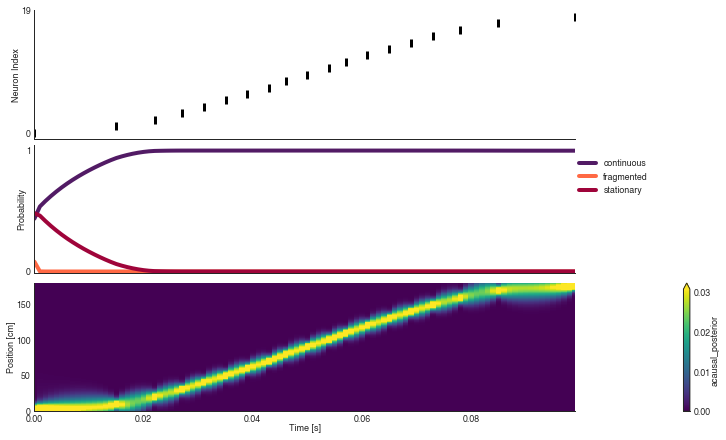

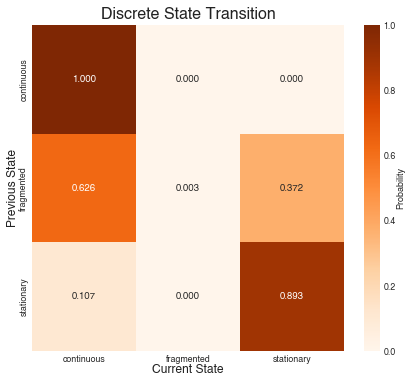

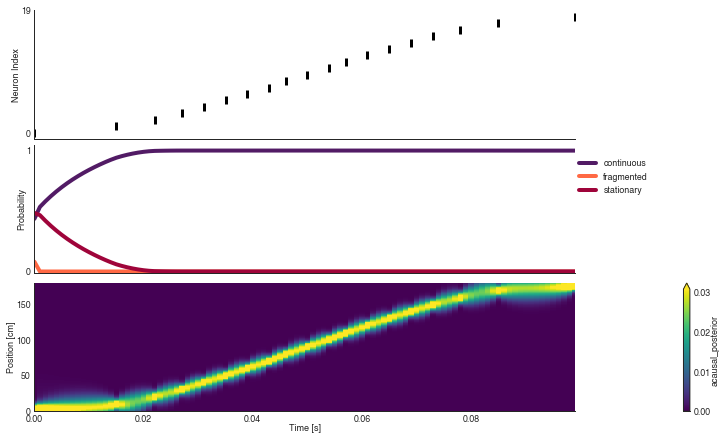

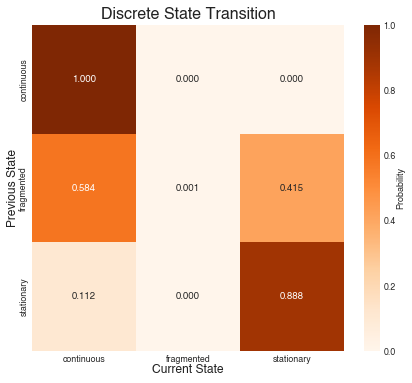

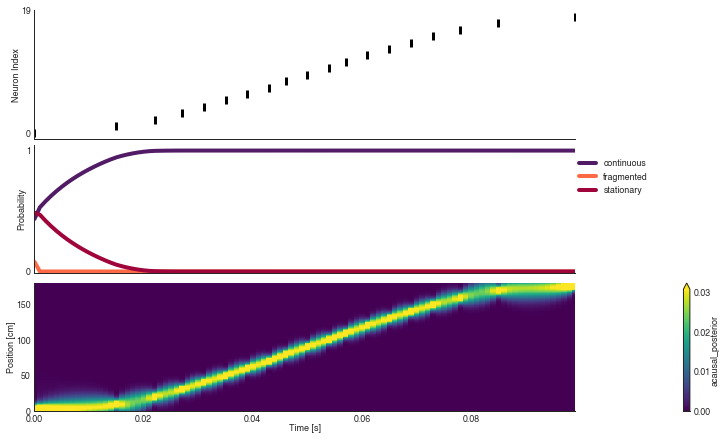

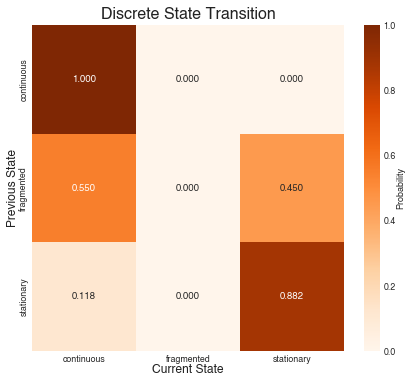

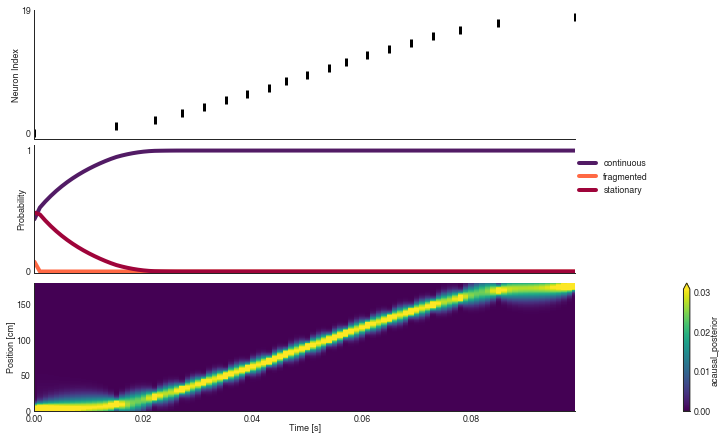

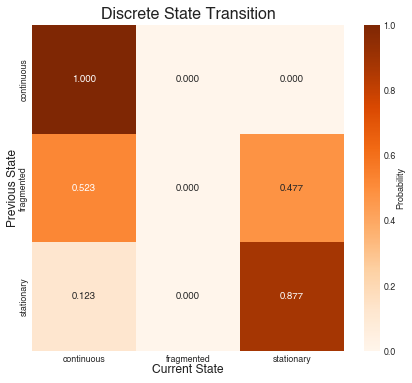

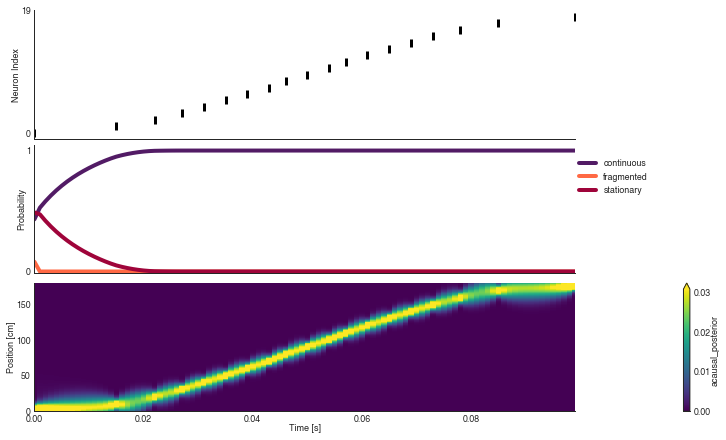

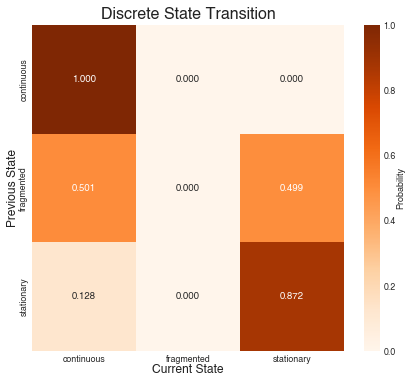

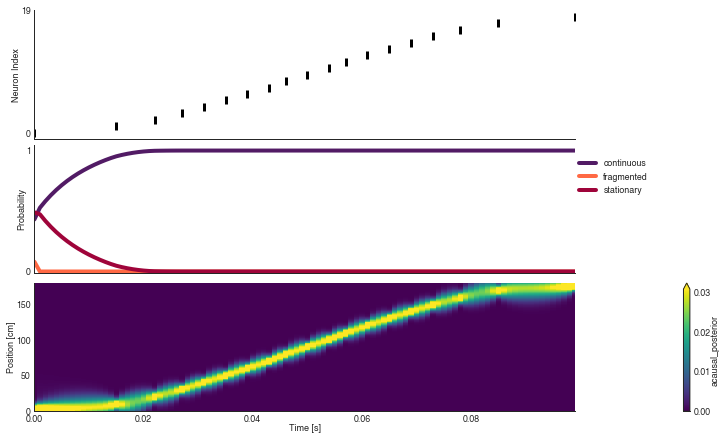

In [20]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)

_, test_spikes1 = make_continuous_replay()

test_spikes = test_spikes1
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

state_names = ['continuous', 'fragmented', 'stationary']

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
print(results.data_log_likelihood)

plt.figure(figsize=(7, 6))  
plot_discrete_state_transition(
    classifier.discrete_state_transition_, state_names=state_names)

for _ in range(10):
    old_discrete_state_transition = classifier.discrete_state_transition_
    causal_prob = results.causal_posterior.sum('position').values
    acausal_prob = results.acausal_posterior.sum('position').values
    A = estimate_discrete_state_transition(old_discrete_state_transition, causal_prob, acausal_prob)
    plt.figure(figsize=(7, 6))  
    plot_discrete_state_transition(A, state_names=state_names)
    
    classifier.discrete_state_transition_ = A
    results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
    plot_classification(replay_time, test_spikes, results)

    print(results.data_log_likelihood)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


-53.238877294284556


INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-50.85103793722983


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-50.374010795011415


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-50.26565793757311


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-50.23878351326108


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-50.22985837144735


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-50.22692265565416


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-50.225995630741146


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-50.22570970629224


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-50.22562232125215


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-50.22559522005541


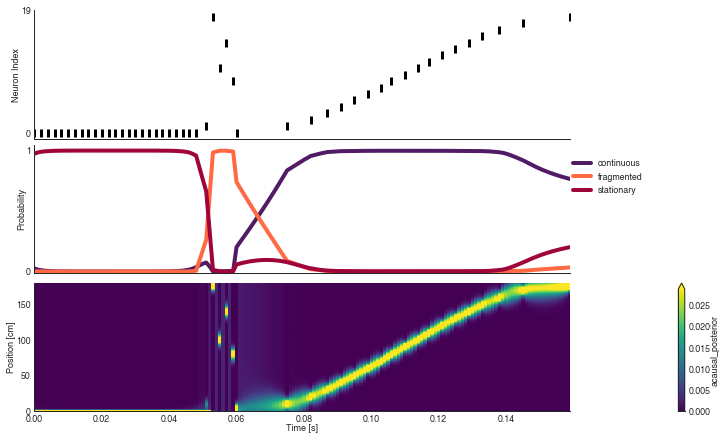

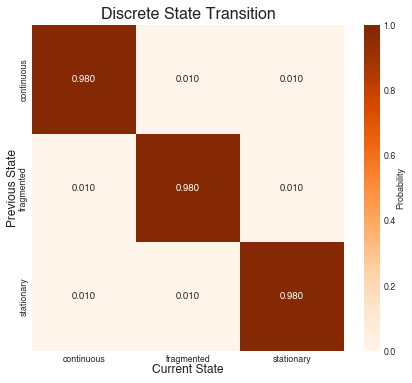

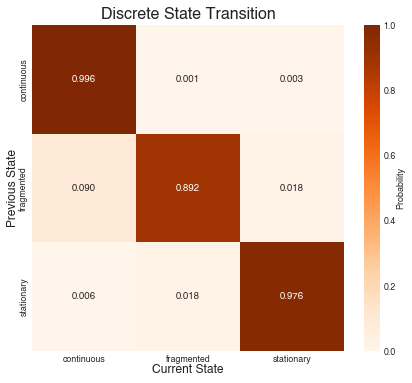

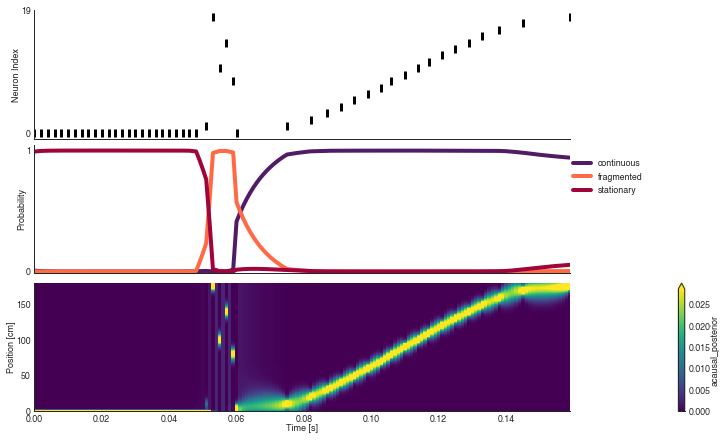

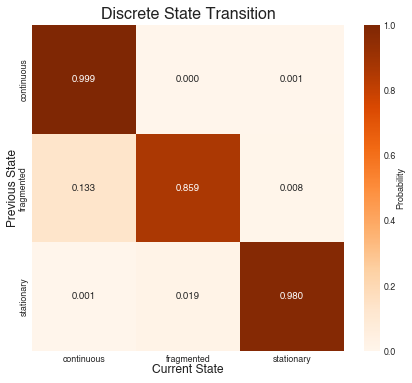

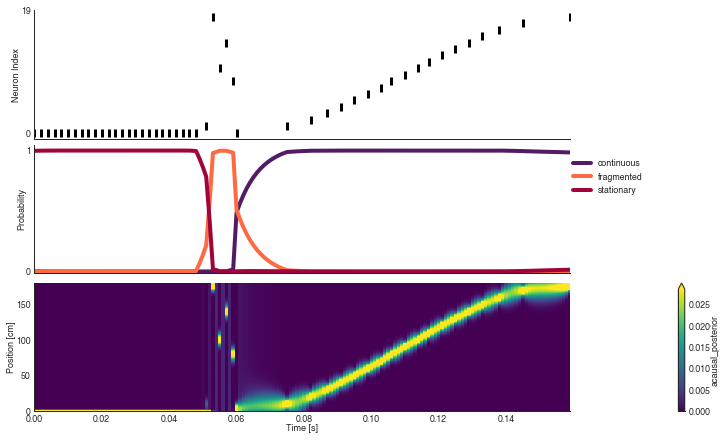

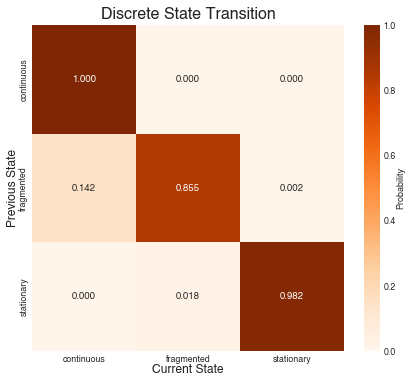

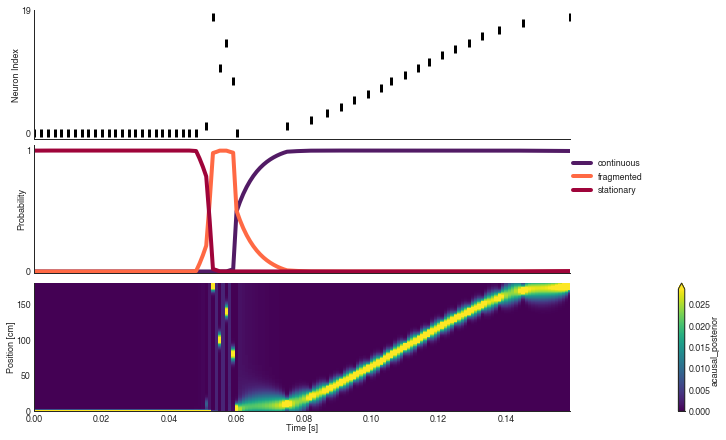

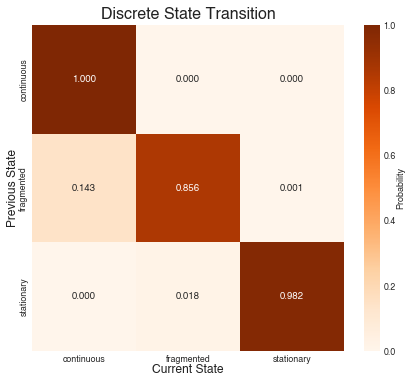

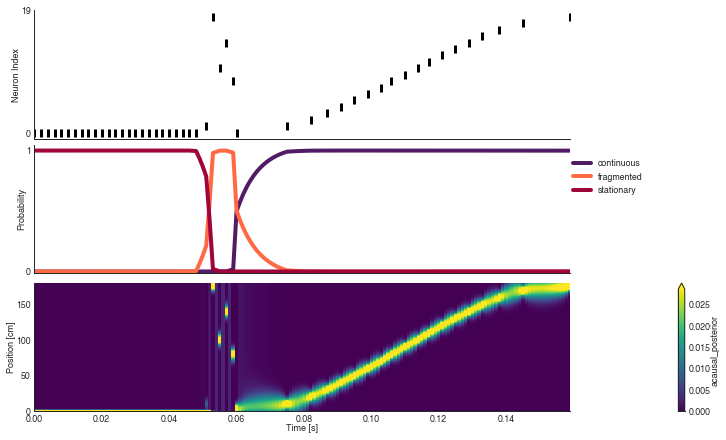

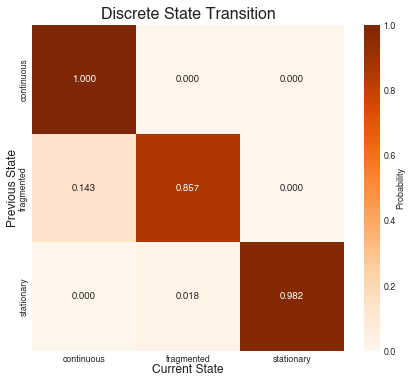

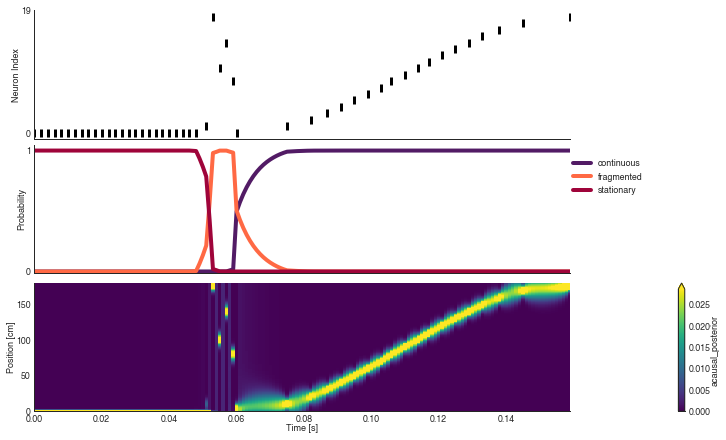

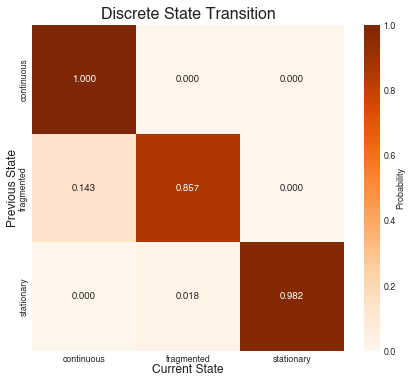

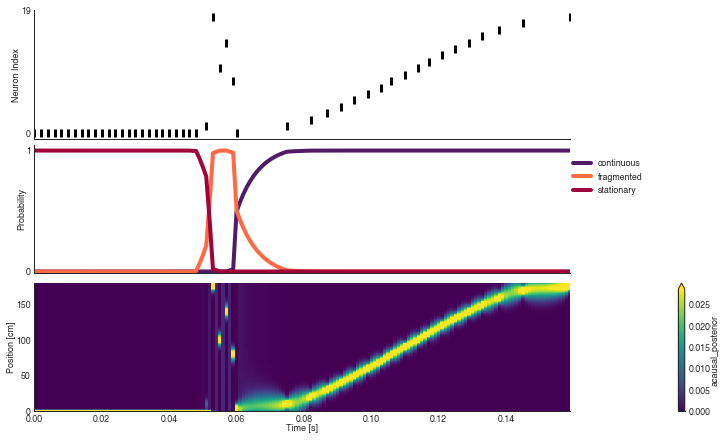

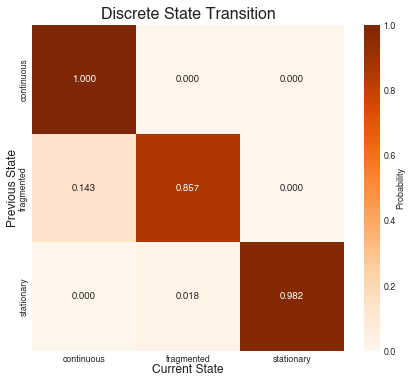

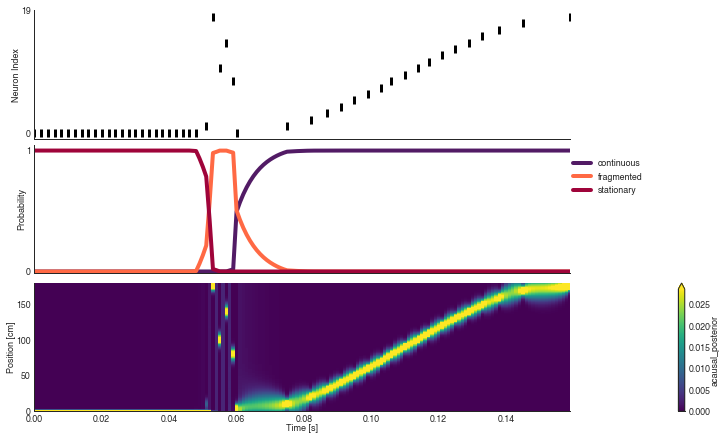

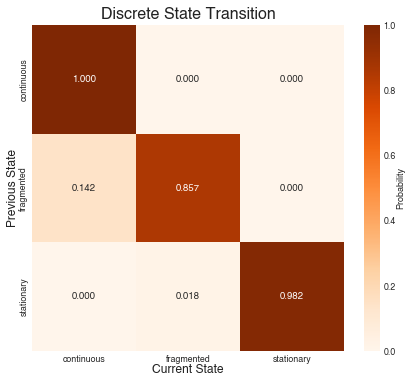

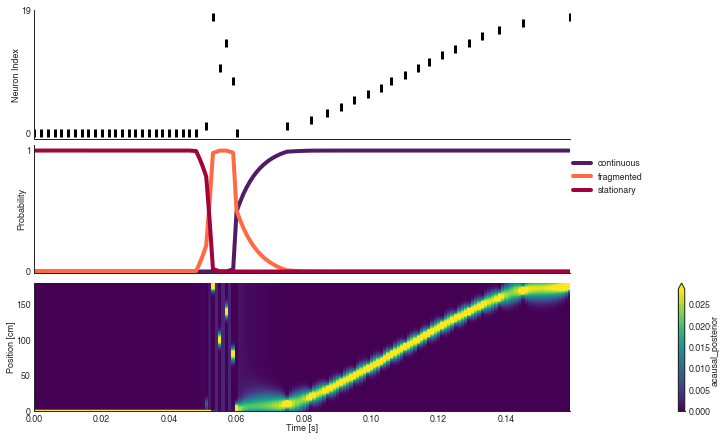

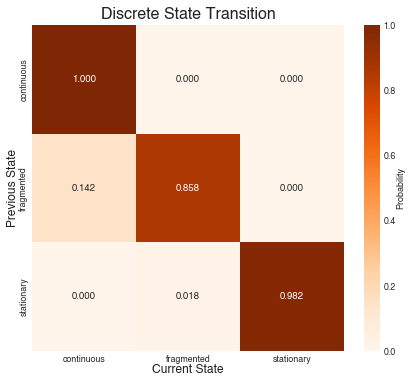

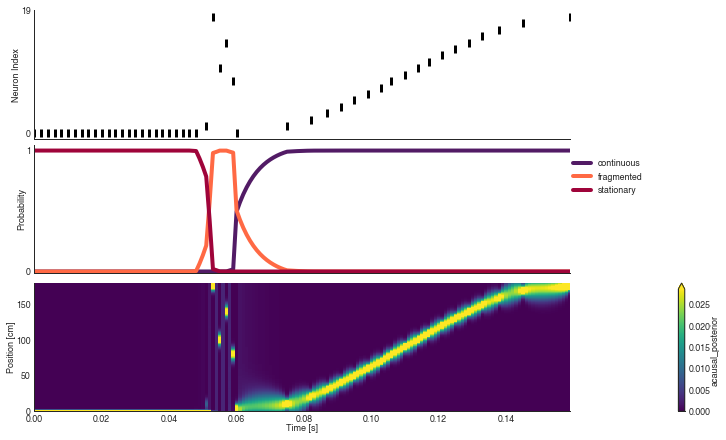

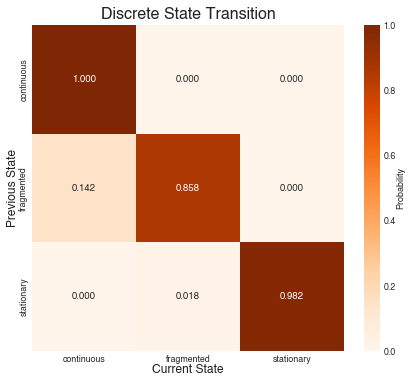

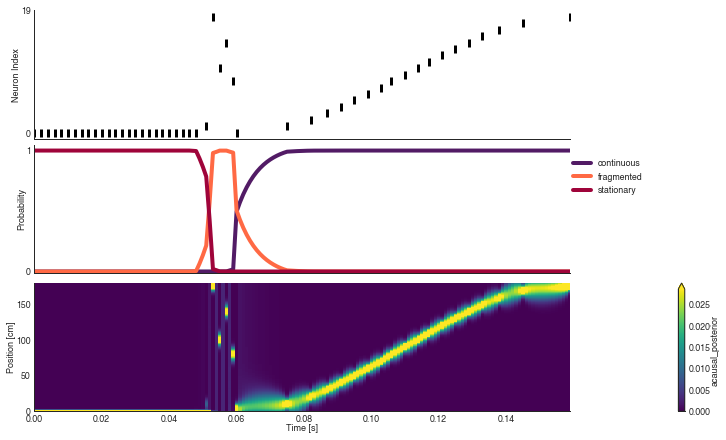

In [21]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)

_, test_spikes1 = make_hover_replay(hover_neuron_ind=0)
_, test_spikes2 = make_fragmented_replay()
_, test_spikes3 = make_continuous_replay()

test_spikes = np.concatenate((test_spikes1, test_spikes2, test_spikes3))
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

state_names = ['continuous', 'fragmented', 'stationary']

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
print(results.data_log_likelihood)

plt.figure(figsize=(7, 6))  
plot_discrete_state_transition(
    classifier.discrete_state_transition_, state_names=state_names)

for _ in range(10):
    old_discrete_state_transition = classifier.discrete_state_transition_
    causal_prob = results.causal_posterior.sum('position').values
    acausal_prob = results.acausal_posterior.sum('position').values
    A = estimate_discrete_state_transition(old_discrete_state_transition, causal_prob, acausal_prob)
    plt.figure(figsize=(7, 6))  
    plot_discrete_state_transition(A, state_names=state_names)
    
    classifier.discrete_state_transition_ = A
    results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
    plot_classification(replay_time, test_spikes, results)

    print(results.data_log_likelihood)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-32.921163106290706


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-30.998550186485698


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-30.8159627453027


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-30.76599738945608


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-30.75503459381385


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-30.752017006896594


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-30.751116832745314


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-30.750842417758037


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-30.750758141751827


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-30.750732219583387


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-30.750724248607234


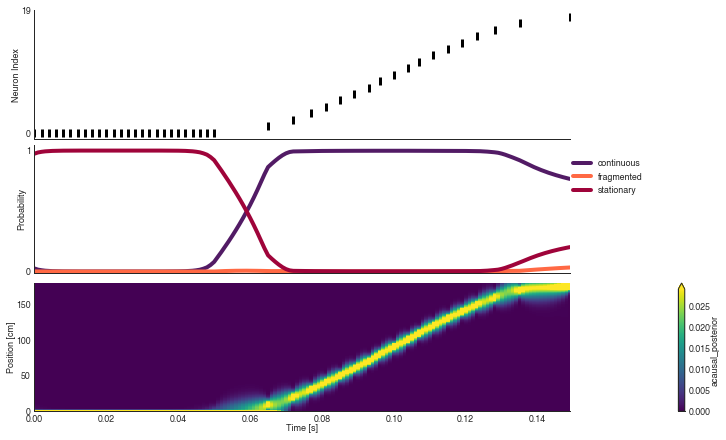

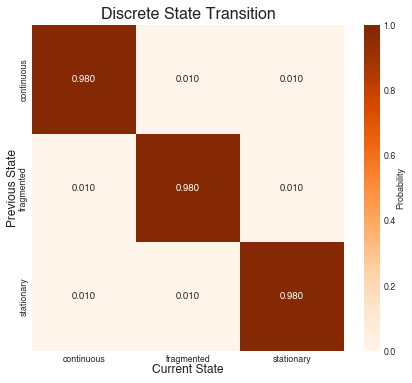

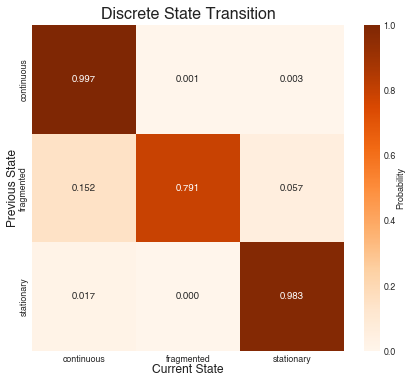

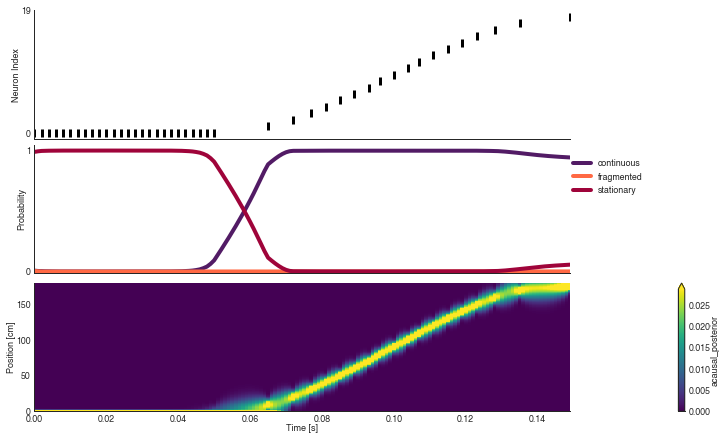

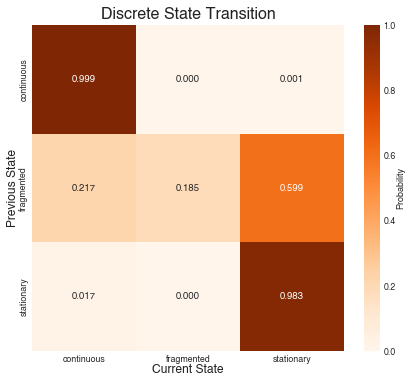

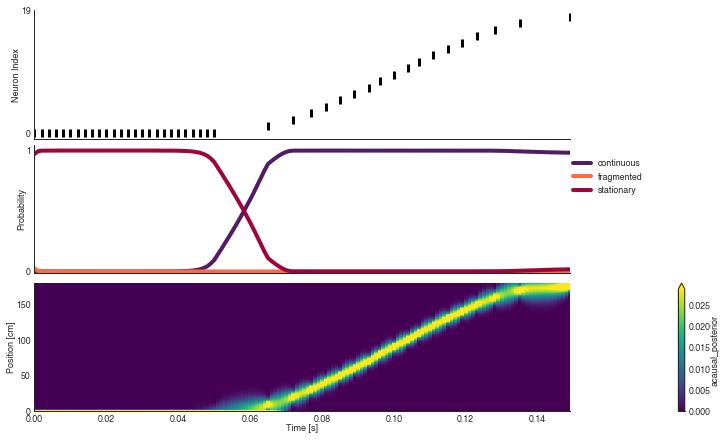

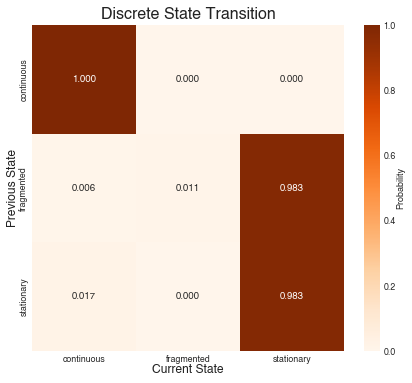

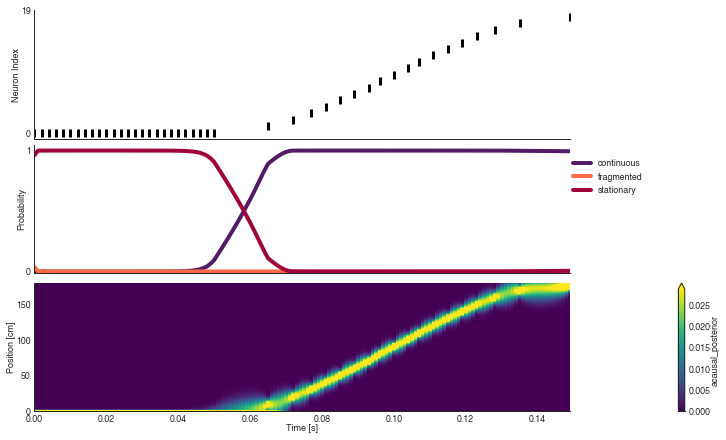

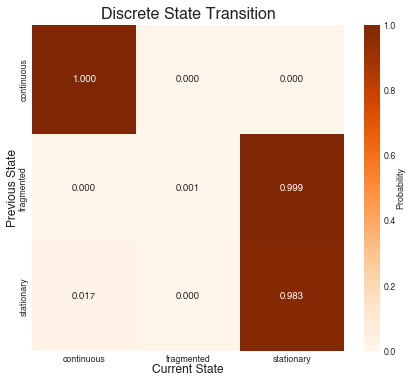

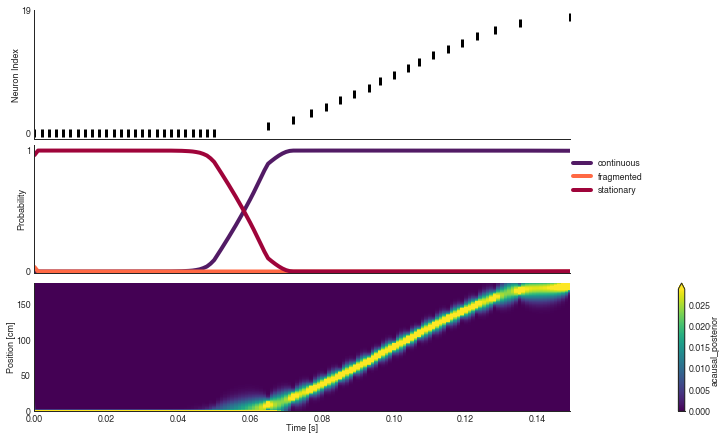

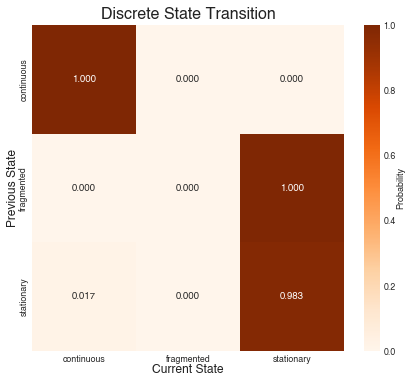

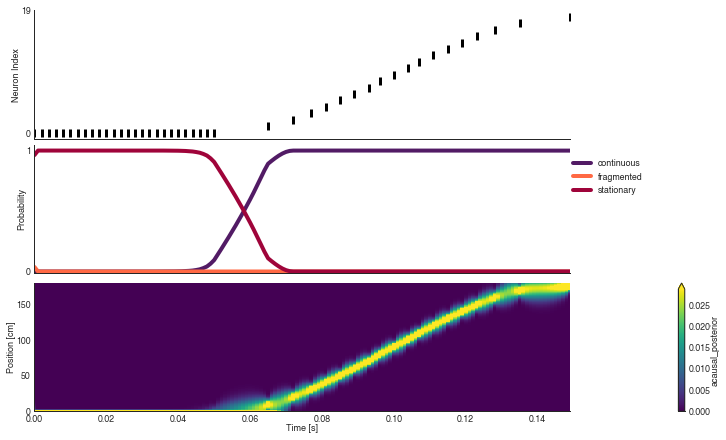

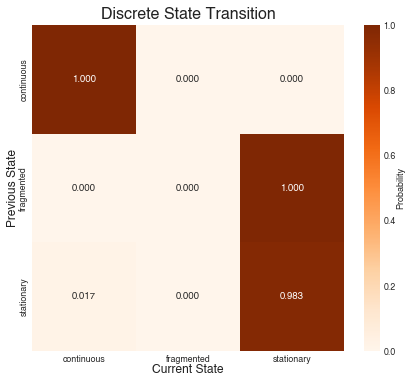

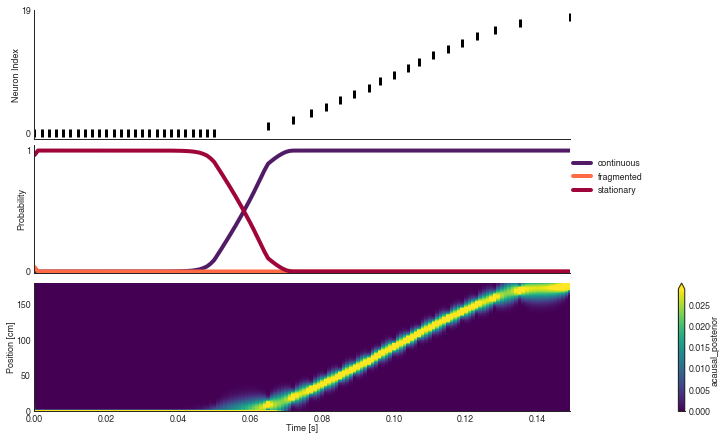

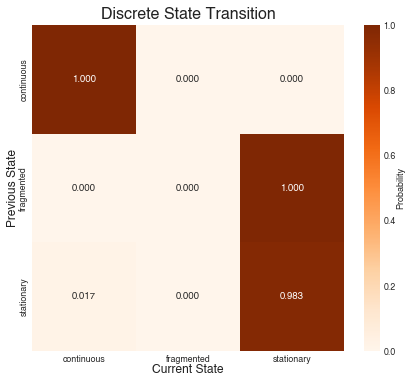

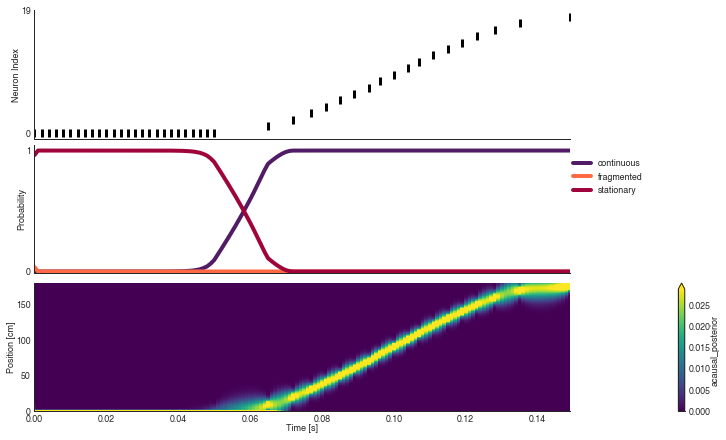

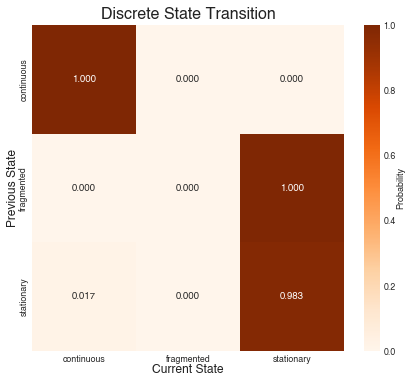

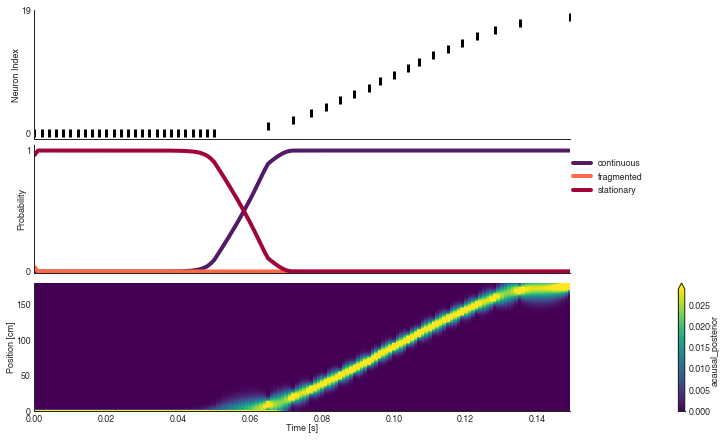

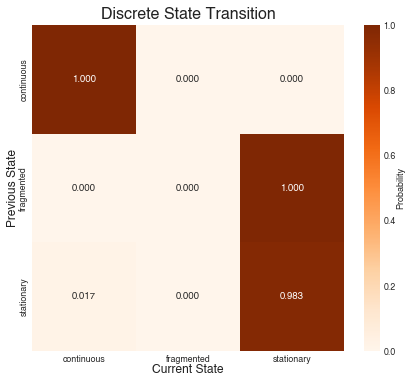

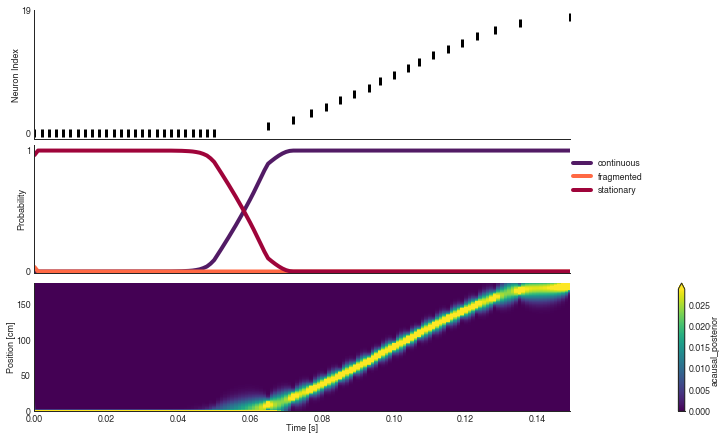

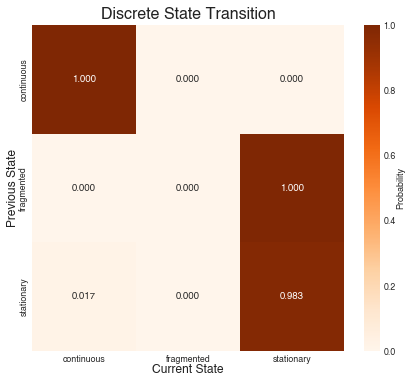

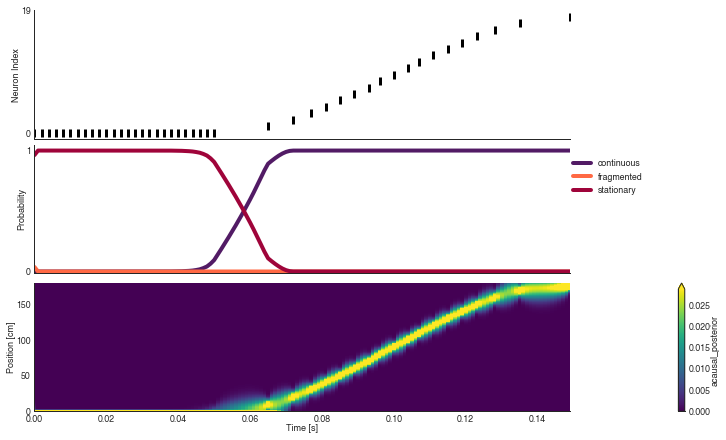

In [22]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay


from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)

_, test_spikes1 = make_hover_replay(hover_neuron_ind=0)
_, test_spikes3 = make_continuous_replay()

test_spikes = np.concatenate((test_spikes1, test_spikes3))
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

state_names = ['continuous', 'fragmented', 'stationary']

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
print(results.data_log_likelihood)

plt.figure(figsize=(7, 6))  
plot_discrete_state_transition(
    classifier.discrete_state_transition_, state_names=state_names)

for _ in range(10):
    old_discrete_state_transition = classifier.discrete_state_transition_
    causal_prob = results.causal_posterior.sum('position').values
    acausal_prob = results.acausal_posterior.sum('position').values
    A = estimate_discrete_state_transition(old_discrete_state_transition, causal_prob, acausal_prob)
    plt.figure(figsize=(7, 6))  
    plot_discrete_state_transition(A, state_names=state_names)
    
    classifier.discrete_state_transition_ = A
    results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
    plot_classification(replay_time, test_spikes, results)

    print(results.data_log_likelihood)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-22.94689487045961


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-22.14852210992407


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-21.8693554273956


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-21.704329528380068


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-21.632477248608993


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-21.602673422751202


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-21.5884676382727


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-21.581239938401563


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-21.577516199765935


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-21.57559193579821


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-21.57459619158759


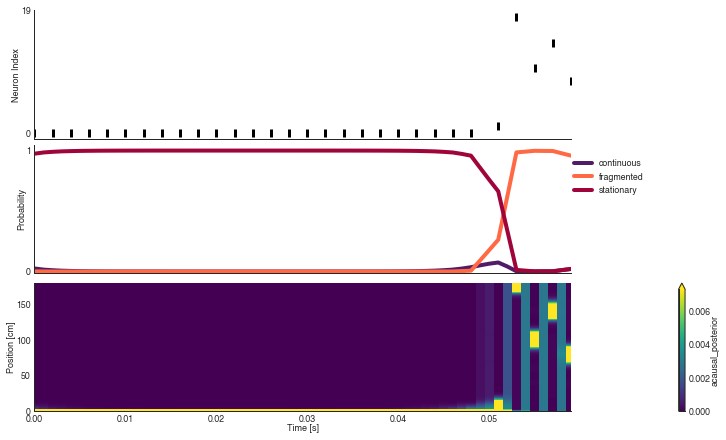

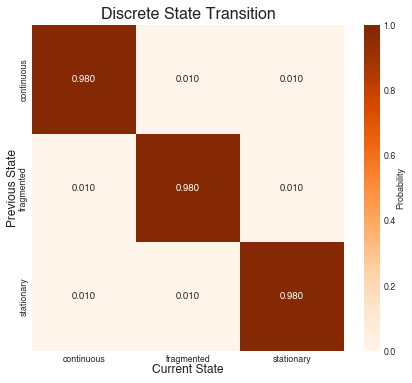

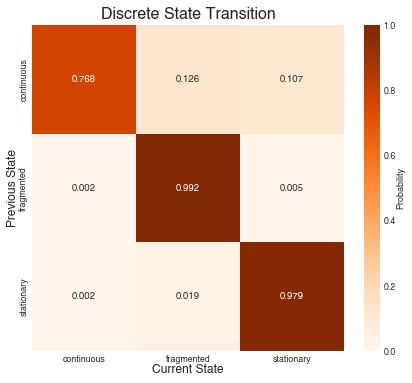

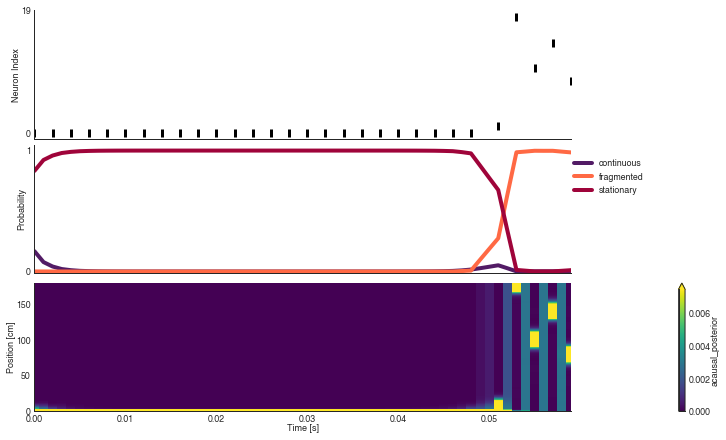

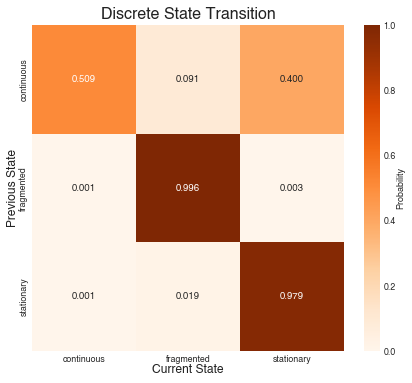

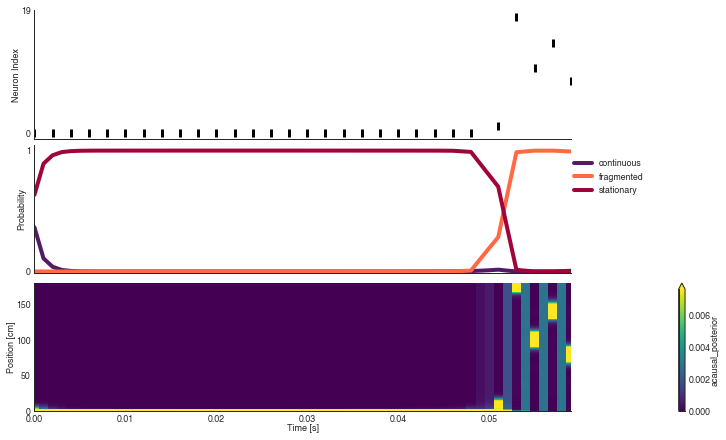

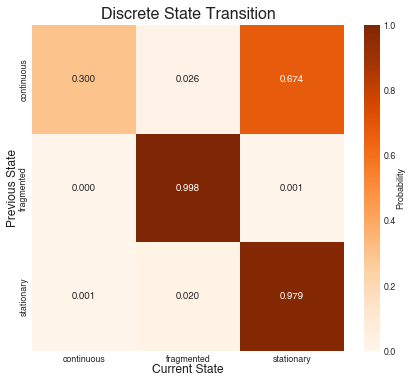

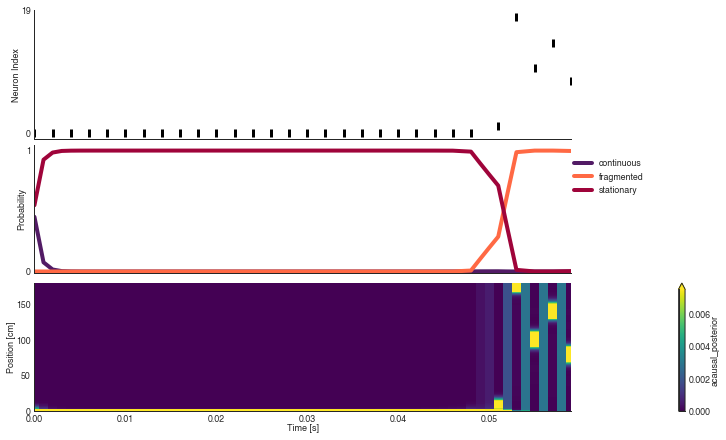

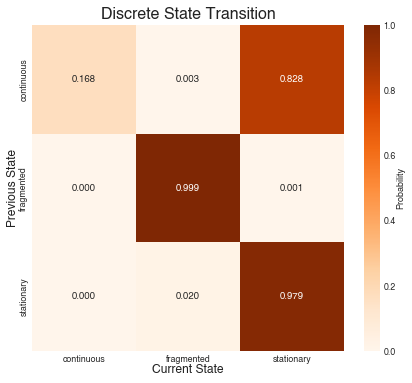

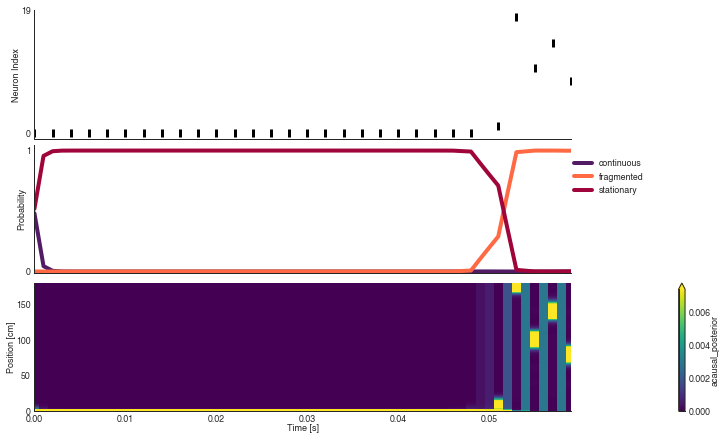

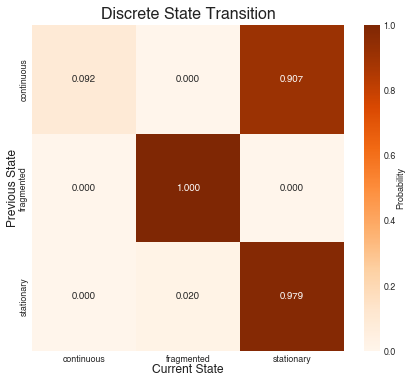

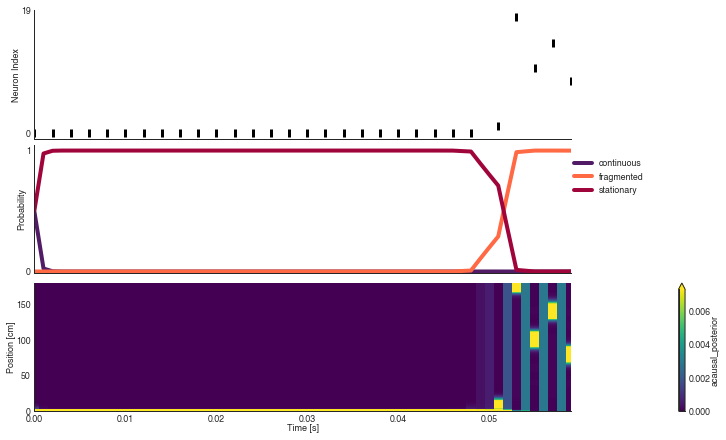

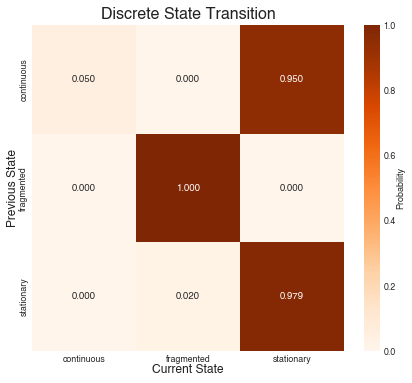

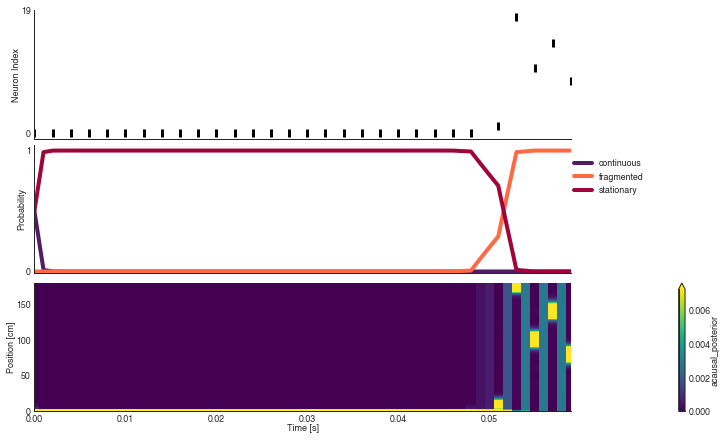

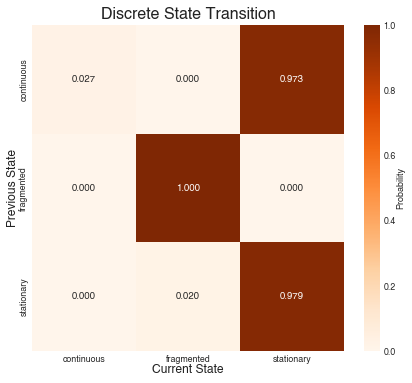

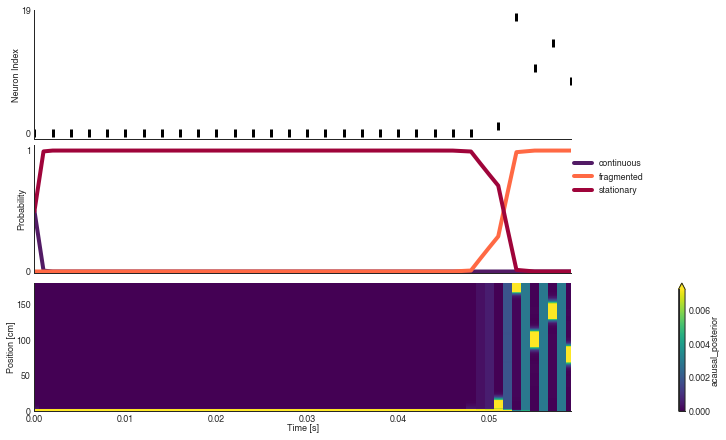

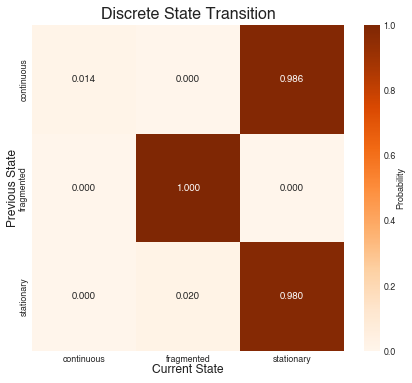

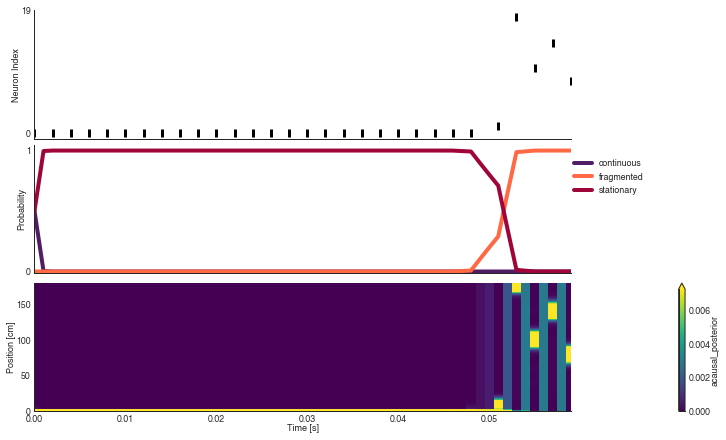

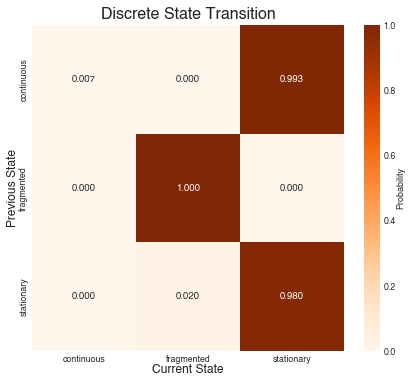

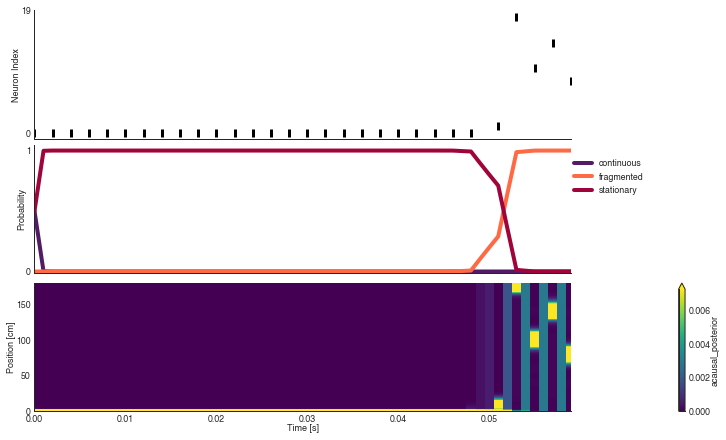

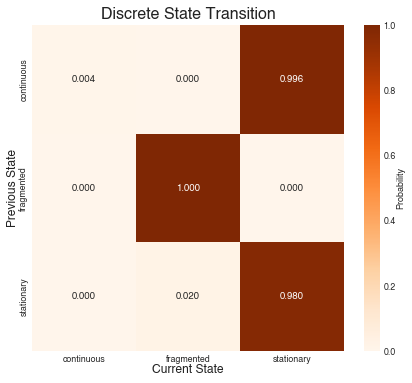

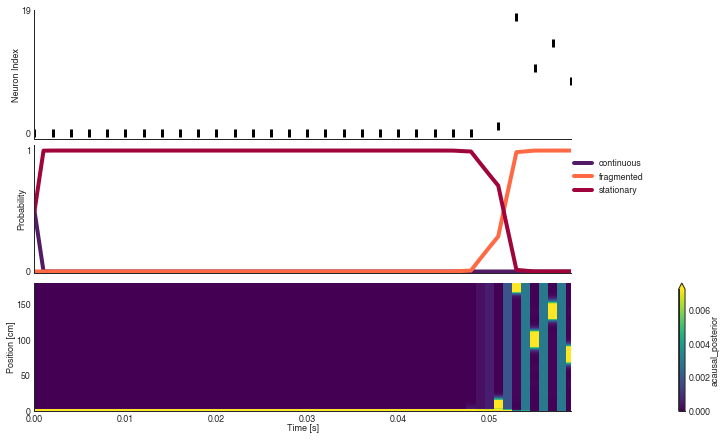

In [23]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay


from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)

_, test_spikes1 = make_hover_replay(hover_neuron_ind=0)
_, test_spikes2 = make_fragmented_replay()

test_spikes = np.concatenate((test_spikes1, test_spikes2))
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

state_names = ['continuous', 'fragmented', 'stationary']

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
print(results.data_log_likelihood)

plt.figure(figsize=(7, 6))  
plot_discrete_state_transition(
    classifier.discrete_state_transition_, state_names=state_names)

for _ in range(10):
    old_discrete_state_transition = classifier.discrete_state_transition_
    causal_prob = results.causal_posterior.sum('position').values
    acausal_prob = results.acausal_posterior.sum('position').values
    A = estimate_discrete_state_transition(old_discrete_state_transition, causal_prob, acausal_prob)
    plt.figure(figsize=(7, 6))  
    plot_discrete_state_transition(A, state_names=state_names)
    
    classifier.discrete_state_transition_ = A
    results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
    plot_classification(replay_time, test_spikes, results)

    print(results.data_log_likelihood)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


-25.272486974128608


INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-22.8276546013254


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-22.322253239132444


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-22.227017838598826


INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-22.21083186136177


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-22.204002696451063


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-22.200127203359518


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-22.19769730930646


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-22.196082841132252


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-22.194966266944935


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-22.19417074362671


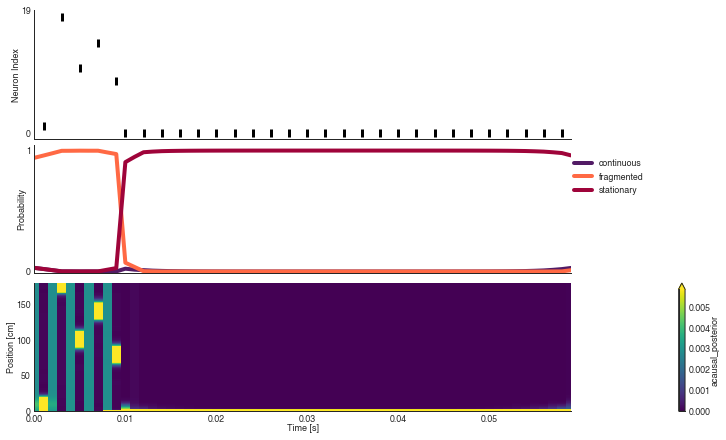

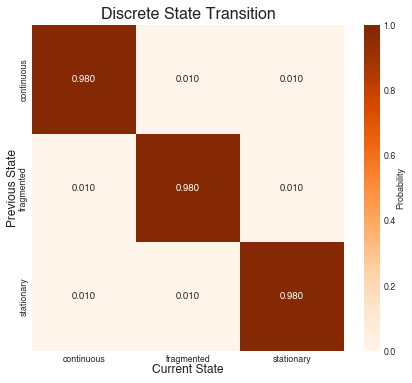

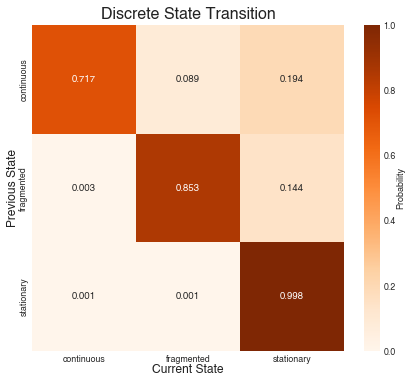

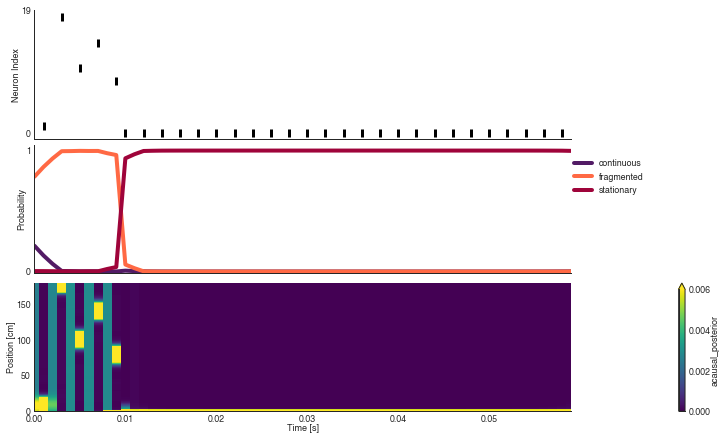

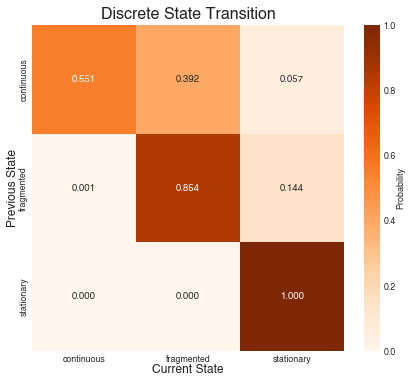

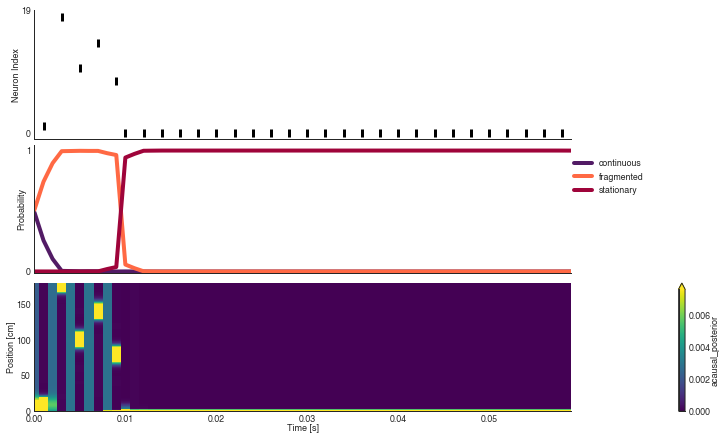

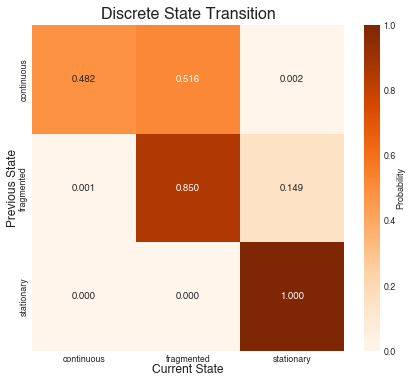

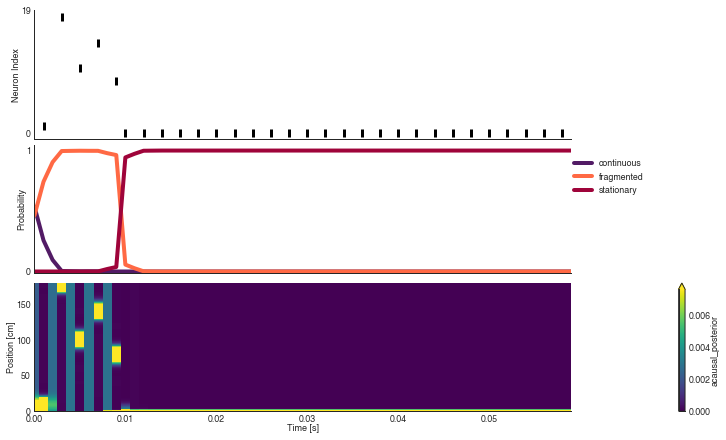

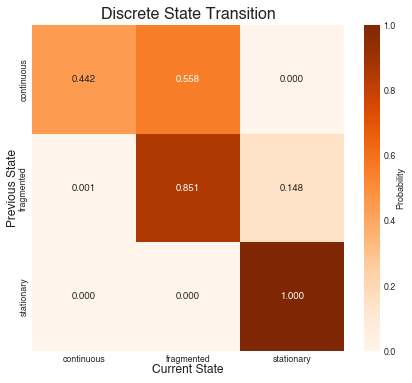

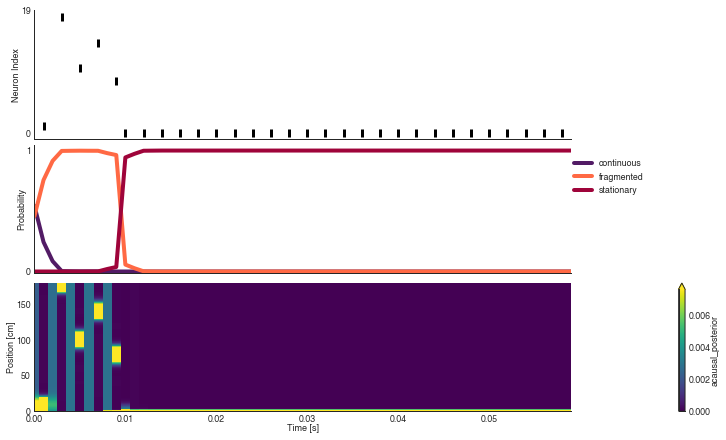

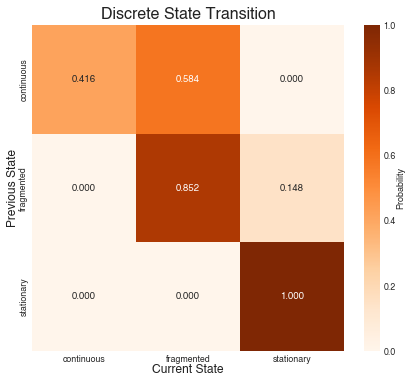

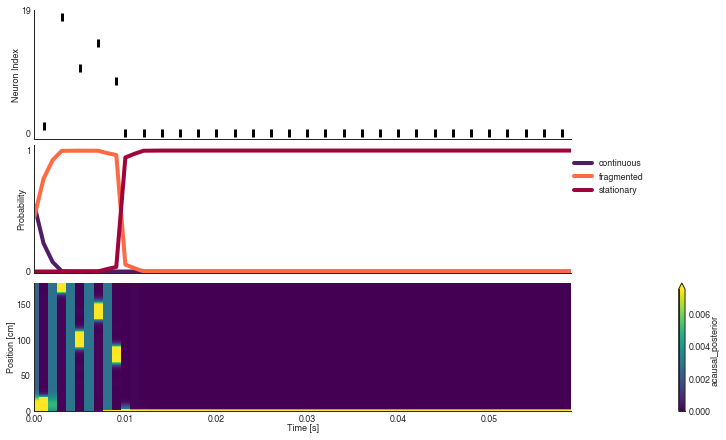

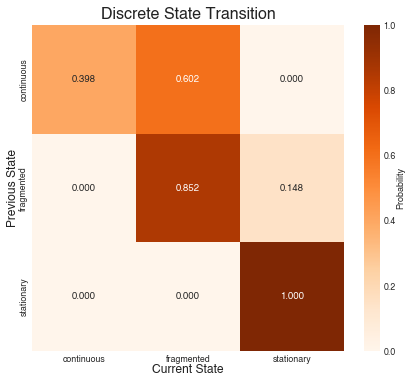

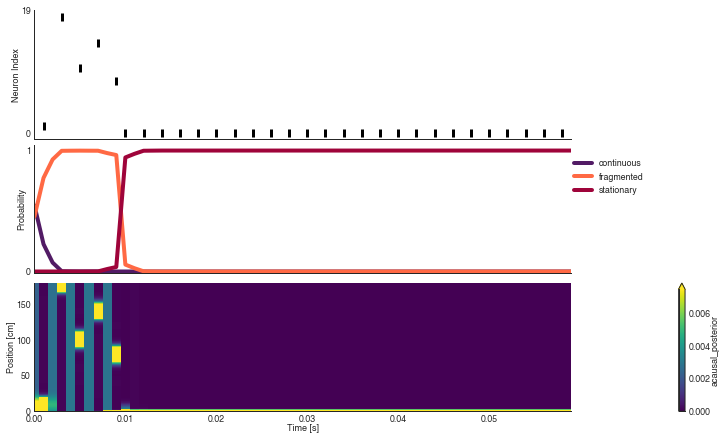

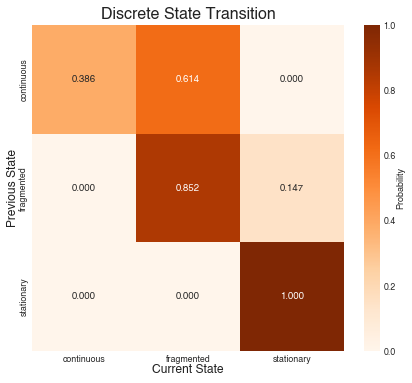

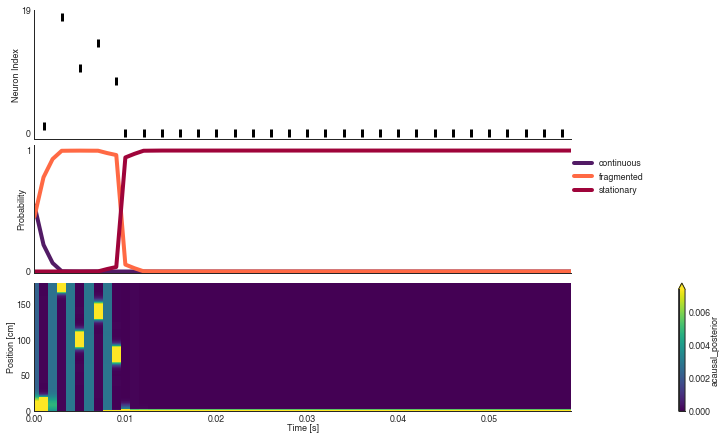

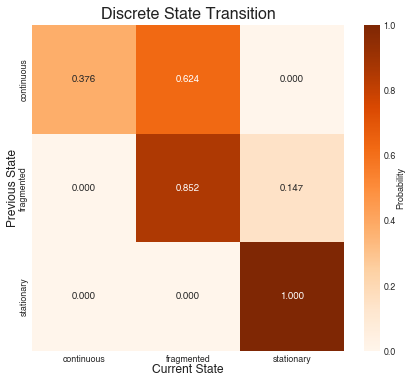

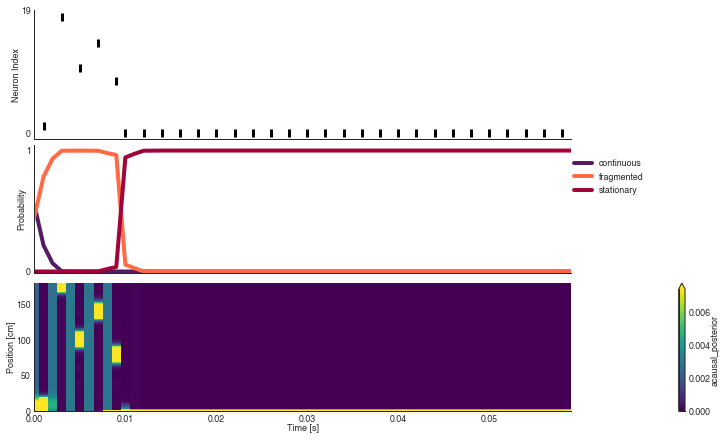

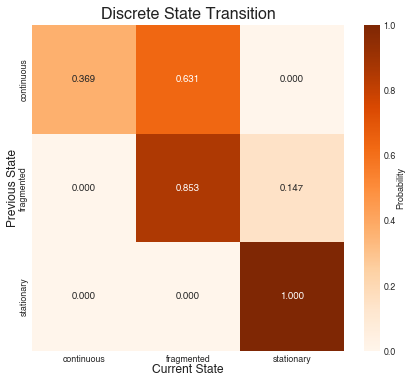

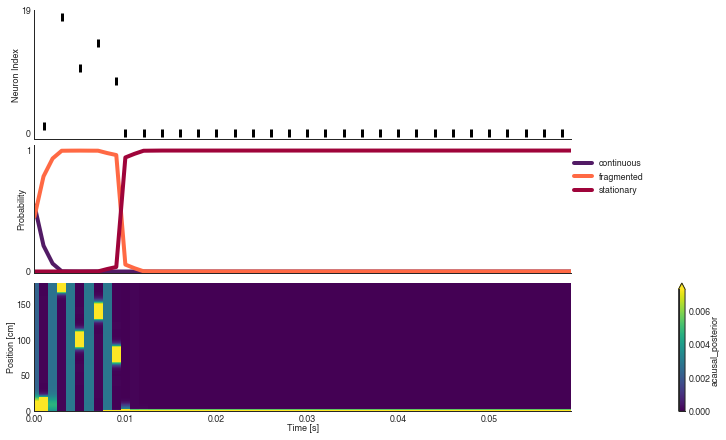

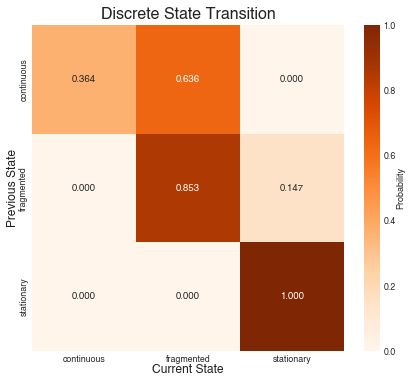

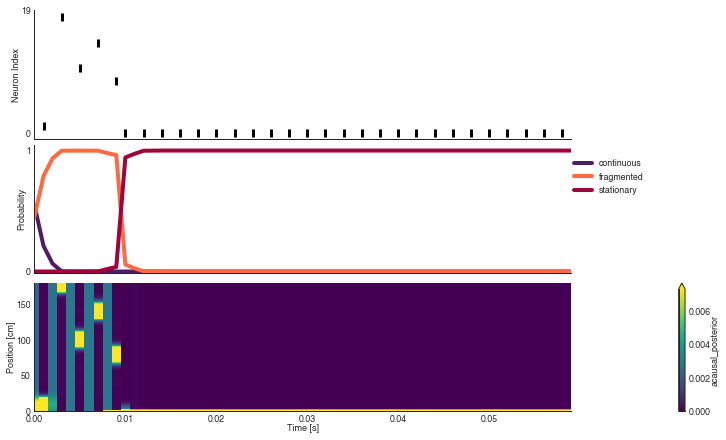

In [24]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay


from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)

_, test_spikes2 = make_fragmented_replay()
_, test_spikes3 = make_hover_replay(hover_neuron_ind=0)

test_spikes = np.concatenate((test_spikes2, test_spikes3))
replay_time = np.arange(test_spikes.shape[0]) / sampling_frequency

state_names = ['continuous', 'fragmented', 'stationary']

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
print(results.data_log_likelihood)

plt.figure(figsize=(7, 6))  
plot_discrete_state_transition(
    classifier.discrete_state_transition_, state_names=state_names)

for _ in range(10):
    old_discrete_state_transition = classifier.discrete_state_transition_
    causal_prob = results.causal_posterior.sum('position').values
    acausal_prob = results.acausal_posterior.sum('position').values
    A = estimate_discrete_state_transition(old_discrete_state_transition, causal_prob, acausal_prob)
    plt.figure(figsize=(7, 6))  
    plot_discrete_state_transition(A, state_names=state_names)
    
    classifier.discrete_state_transition_ = A
    results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
    plot_classification(replay_time, test_spikes, results)

    print(results.data_log_likelihood)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...


-227.58204282921295


INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-216.92947514553586


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-215.54865957319151


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-214.93072491737075


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-214.5920579057003


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-214.39068740315815


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-214.26377471704416


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-214.17965149206347


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-214.12137773989184


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...


-214.07950738070156


INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


-214.0485453014252


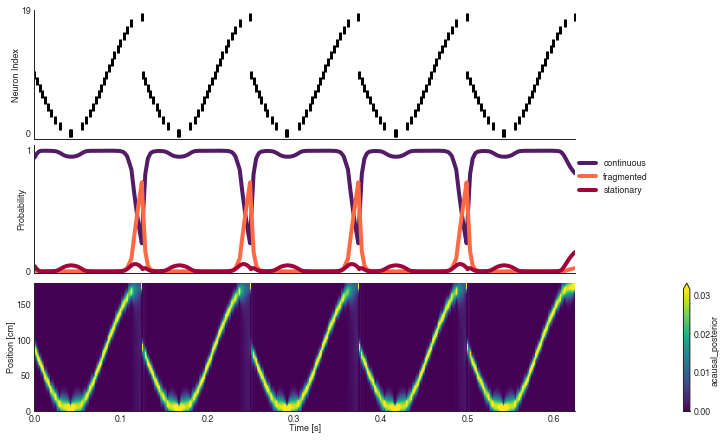

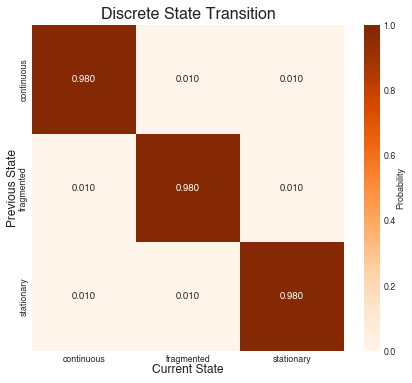

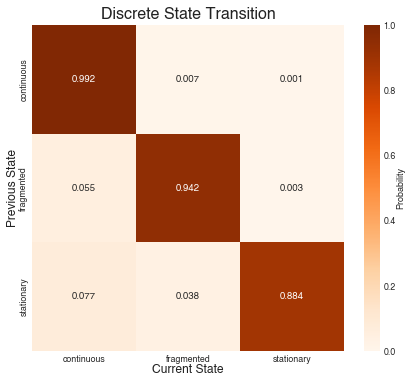

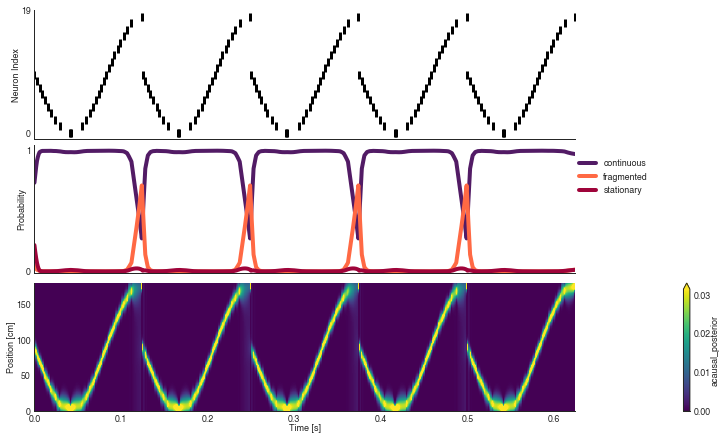

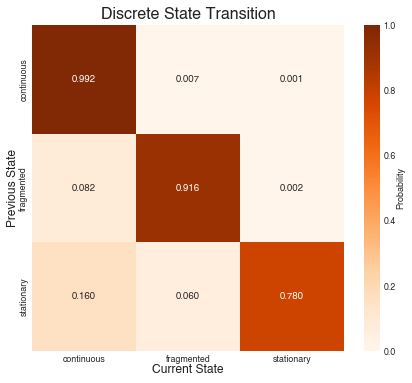

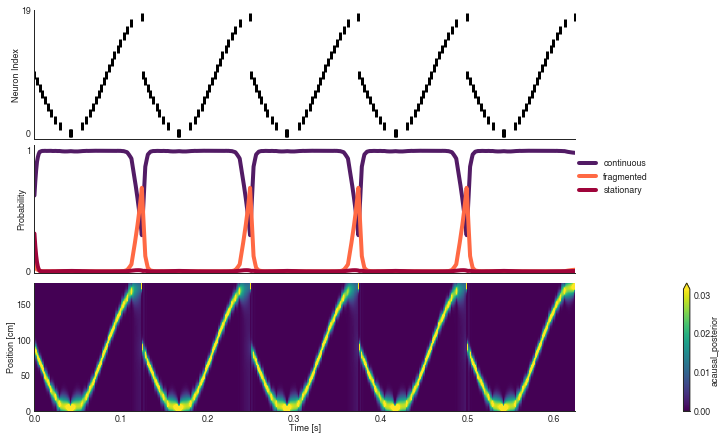

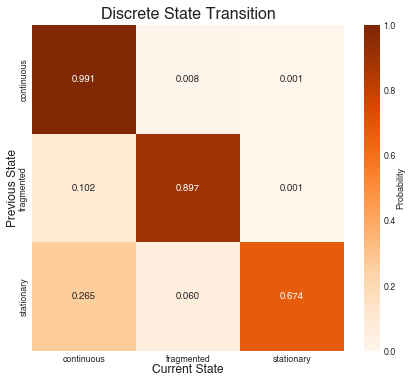

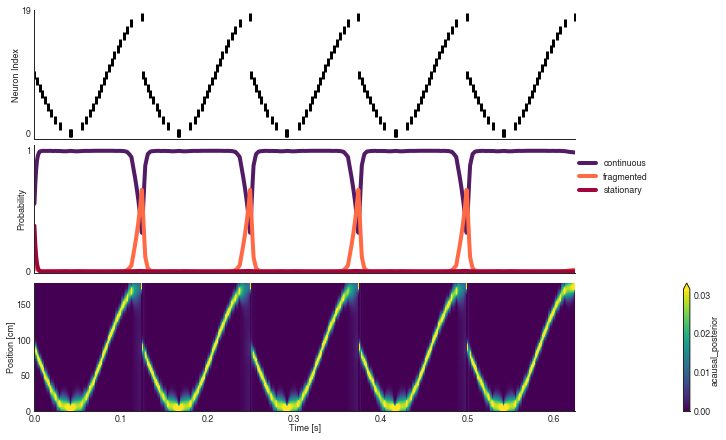

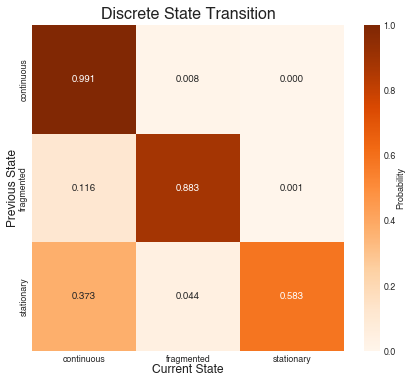

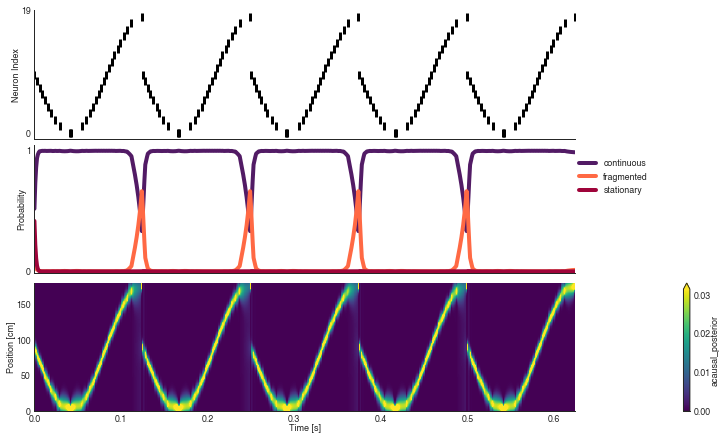

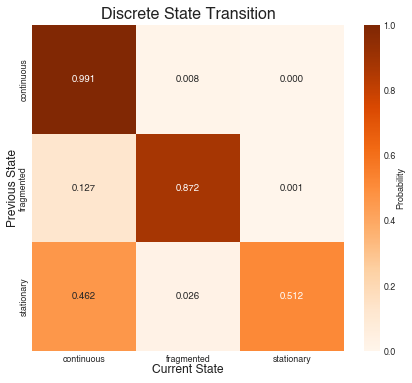

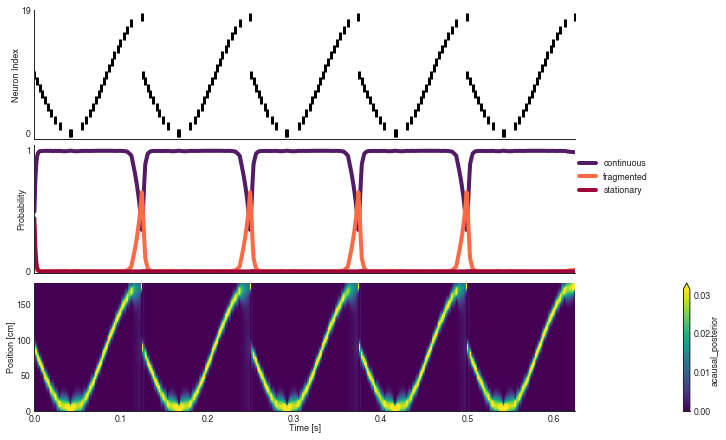

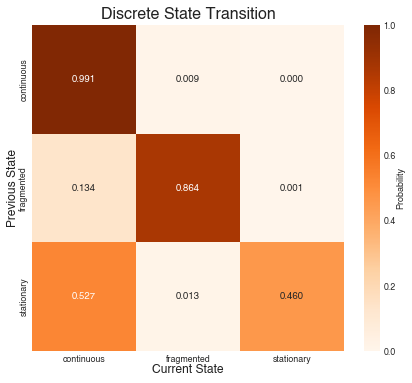

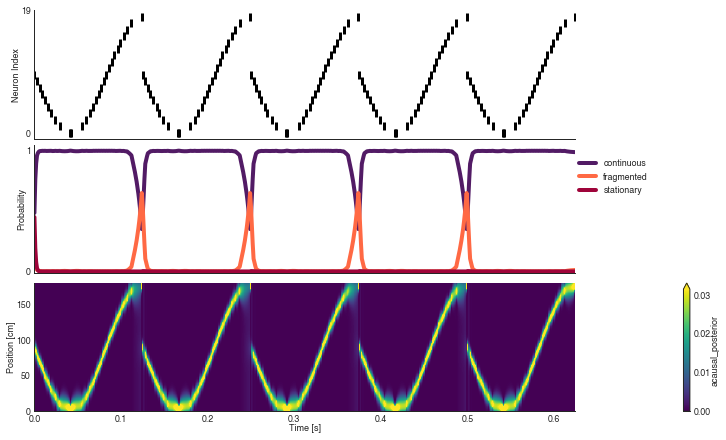

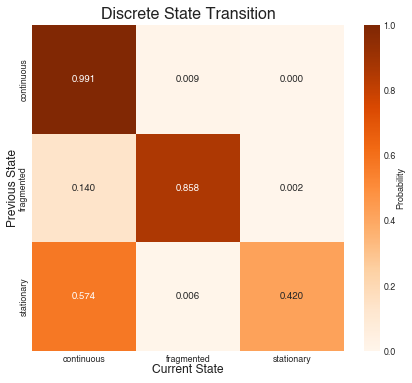

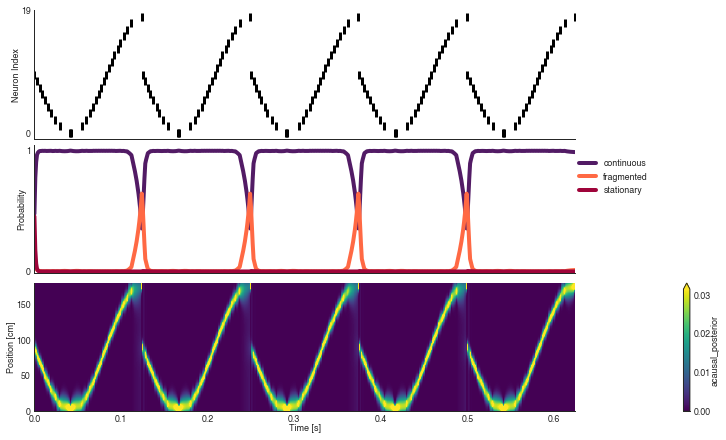

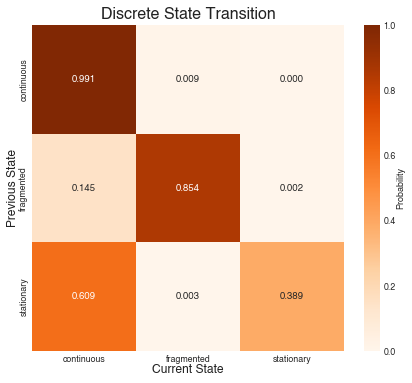

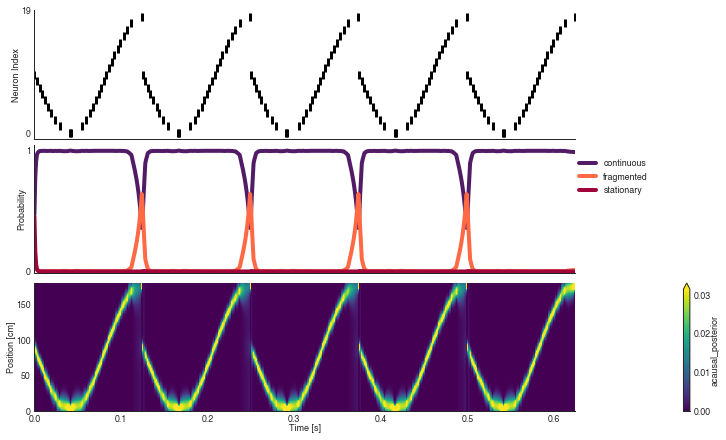

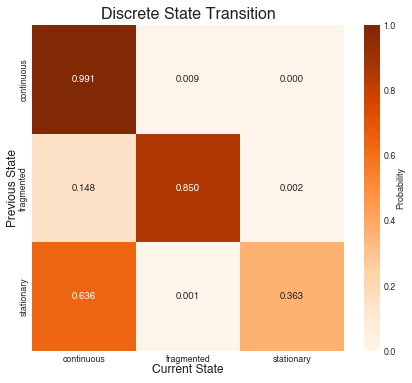

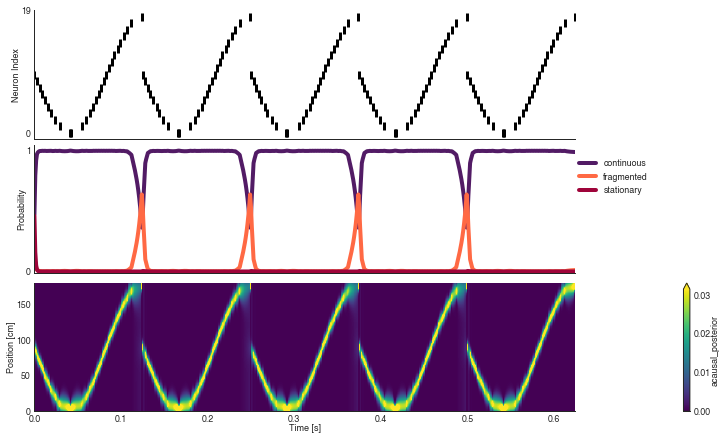

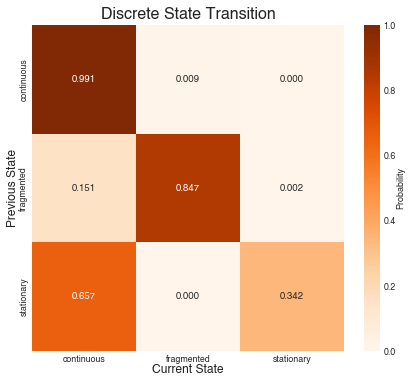

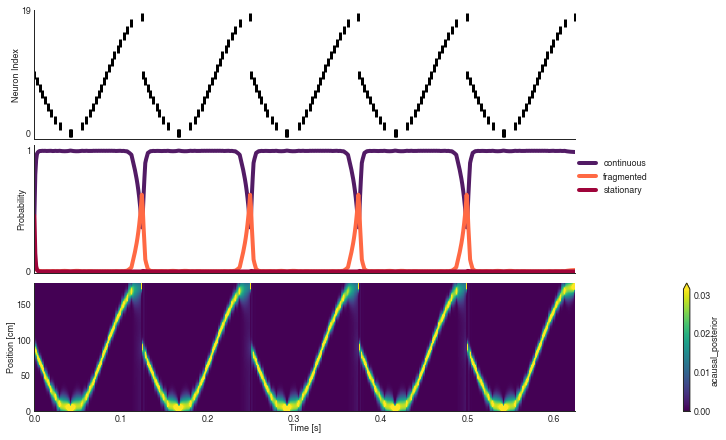

In [25]:
from replay_trajectory_classification.sorted_spikes_simulation import make_theta_sweep


from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)

replay_time, test_spikes = make_theta_sweep()

state_names = ['continuous', 'fragmented', 'stationary']

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)
print(results.data_log_likelihood)

plt.figure(figsize=(7, 6))  
plot_discrete_state_transition(
    classifier.discrete_state_transition_, state_names=state_names)

for _ in range(10):
    old_discrete_state_transition = classifier.discrete_state_transition_
    causal_prob = results.causal_posterior.sum('position').values
    acausal_prob = results.acausal_posterior.sum('position').values
    A = estimate_discrete_state_transition(old_discrete_state_transition, causal_prob, acausal_prob)
    plt.figure(figsize=(7, 6))  
    plot_discrete_state_transition(A, state_names=state_names)
    
    classifier.discrete_state_transition_ = A
    results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
    plot_classification(replay_time, test_spikes, results)

    print(results.data_log_likelihood)